### Link to the dataset: https://www.kaggle.com/datasets/asdasdasasdas/garbage-classification

In [1]:
from google.colab import files

# Upload the Kaggle API key file (kaggle.json) that you downloaded from Kaggle
uploaded = files.upload()

# Move the uploaded API key to the required directory
!mkdir -p ~/.kaggle
!mv kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

Saving kaggle.json to kaggle.json


In [ ]:
!pip install kaggle

In [3]:
!kaggle datasets download -d asdasdasasdas/garbage-classification

 99% 81.0M/82.0M [00:04<00:00, 21.4MB/s]
100% 82.0M/82.0M [00:04<00:00, 17.4MB/s]


In [ ]:
!unzip garbage-classification.zip

In [ ]:
# !pip install rembg

In [5]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
import tensorflow as tf
import pickle

import cv2
# from rembg import remove
from PIL import Image
from IPython.display import display

import os
import shutil
from shutil import copyfile

from sklearn.metrics import classification_report, confusion_matrix
from sklearn.utils.class_weight import compute_class_weight

# Functions

## Split data

In [6]:
def create_train_valid_test_dirs(root_path, subdir_names, train_valid_test_names=['train', 'valid', 'test']):
    """ Function for creating separate folders that contain data for training, validation and testing of the model
    Args:
        1) root_path - the path to the parent folder in which you want to create subfolders
        2) subdir_names - a list of label class names (subfolders with the specified names will be created in each of the train, valid, and test folders)
        3) train_valid_test_names - a list of names of training, validation and test samples
    Returns:
        None; but creates folders
    """
    parent_directories = []
    for dir_name in train_valid_test_names:
        parent_directories.append(os.path.join(root_path, dir_name))

    for directory in parent_directories:
        if not os.path.exists(directory):
            os.makedirs(directory)
        for subdirectory in subdir_names:
            subdir_name = os.path.join(directory + '/', subdirectory)
            if not os.path.exists(subdir_name):
                os.makedirs(subdir_name)

In [7]:
def split_data(source_dir_path, train_dir_path, valid_dir_path, test_dir_path, train_test_split=0.8, train_valid_split=0.85, random_sample=True):
    """ Function to split the files of the specified folder into training, validation and test samples by copying
    the files from source_dir_path to the corresponding folders
    Args:
        1) source_dir_path - the path to the folder containing the original data to be split into train/valid/test
        2) train_dir_path - the path to the folder that will contain the training data
        3) valid_dir_path - the path to the folder that will contain the validation data
        4) test_dir_path - the path to the folder that will contain the test data
        5) train_test_split - the ratio between training and test samples ([0; 1])
        6) train_valid_split - the ratio between training and validation samples ([0; 1])
        7) random_sample - whether files need to be shuffled randomly before splitting into training, validation, and test samples
    Returns:
        None, but split the files into training, validation and test samples
    """
    fnames = os.listdir(source_dir_path)

    processed_fnames = []
    for file_name in fnames:
        if os.path.getsize(os.path.join(source_dir_path, file_name)) > 0:
            processed_fnames.append(file_name)
        else:
            print(f'{file_name} is zero length, so ignoring.')

    if random_sample:
        processed_fnames = random.sample(processed_fnames, len(processed_fnames))

    split_index = int(train_test_split * len(processed_fnames))
    train_valid_files = processed_fnames[:split_index]
    test_files = processed_fnames[split_index:]

    split_index = int(train_valid_split * len(train_valid_files))
    train_files = train_valid_files[:split_index]
    valid_files = train_valid_files[split_index:]

    # Copy training files
    for file in train_files:
        source = os.path.join(source_dir_path, file)
        destination = os.path.join(train_dir_path, file)
        copyfile(source, destination)

    # Copy validation files
    for file in valid_files:
        source = os.path.join(source_dir_path, file)
        destination = os.path.join(valid_dir_path, file)
        copyfile(source, destination)

    # Copy test files
    for file in test_files:
        source = os.path.join(source_dir_path, file)
        destination = os.path.join(test_dir_path, file)
        copyfile(source, destination)


In [8]:
def split_class_data(source_dir_path, train_valid_test_paths, class_dir_name, train_test_split=0.8, train_valid_split=0.85, random_sample=True):
    """ Function for dividing the data of one label class into train/valid/test
    Args:
        1) source_dir_path - the path to the folder containing the original data of all label classes which needs to be splitted into train/valid/test;
        2) train_valid_test_paths - the list of paths to the folders of training, validation and test samples
        (the paths are specified in this order: train, valid, test)
        3) class_dir_name - the name of the folder that contains the label class data
        4) train_test_split - the ratio between training and test samples ([0; 1])
        5) train_valid_split - the ratio between training and validation samples ([0; 1])
        6) random_sample - whether files need to be shuffled randomly before splitting into training, validation, and test samples
    Returns:
        None, but split the files of label class into training, validation and test samples
    """
    train_dir_path_class = os.path.join(train_valid_test_paths[0], class_dir_name)
    valid_dir_path_class = os.path.join(train_valid_test_paths[1], class_dir_name)
    test_dir_path_class = os.path.join(train_valid_test_paths[2], class_dir_name)
    source_dir_path_class = os.path.join(source_dir_path, class_dir_name)
    split_data(source_dir_path=source_dir_path_class, train_dir_path=train_dir_path_class, valid_dir_path=valid_dir_path_class,
               test_dir_path=test_dir_path_class,
               train_test_split=train_test_split, train_valid_split=train_valid_split, random_sample=random_sample)

## Display images

In [9]:
def display_image(img, title=None):
    """ Function to display an image
    Args:
        1) img - image object
        2) title - the title that will be displayed above the image
    Returns:
        None; but displays an image
    """
    plt.imshow(img)
    plt.title(title)
    plt.show()

In [10]:
def display_original_augmented_img(original_img, augmented_img, original_title=None, augmented_title=None):
    """ Function to display the original and augmented image on the same graph
    Args:
        1) original_img - object of the original image
        2) augmented_img - augmented image object
        3) original_title - title for the original image
        4) augmented_title - title for the augmented image
    Returns:
        None; but displays images
    """
    fig, axes = plt.subplots(1, 2, figsize=(12, 6))
    axes[0].imshow(original_img)
    axes[0].set_title(original_title)

    axes[1].imshow(augmented_img)
    axes[1].set_title(augmented_title)
    plt.show()

## Display data

In [11]:
def load_display_image(root_path, image_name, title=None):
    """ Function to display an image
    Args:
        1) root_path - the path to the folder that contains the image
        2) image_name - the name of the image
        3) title - the title that will be displayed above the image
    Returns:
        None; but displays an image
    """
    img = cv2.imread(os.path.join(root_path, image_name))
    plt.imshow(img)
    plt.title(title)
    plt.show()

In [12]:
def display_pie_chart(df, column_name, title=None, column_contains_count=False, filename=None):
    """ Function to display the percentage ratio of column (with the name column_name) content
    Args:
        1) df - the original dataframe that contains the required information
        2) column_name - the name of the df dataframe column whose percentage values are to be found
        3) title - the title of the graph
        4) column_contains_count - the dataframe column already contains the number of repetitions of the target values (target value count)
        5) filename - the relative path where the file will be saved (with the file name, the file extension is not required) or just the filename
    Returns:
        None, but plots graph
    """
    # Calculate the percentage of each activity in original_df
    if column_contains_count:
        activity_percentages_df = df[column_name] / sum(df[column_name])
    else:
        activity_percentages_df = df[column_name].value_counts(normalize=True) * 100

    plt.figure(figsize=(12, 6))

    # Plot pie chart for df
    sns.set_palette("Set3")
    plt.pie(activity_percentages_df, labels=activity_percentages_df.index, autopct='%1.1f%%', startangle=140)
    plt.title(title)

    # Adjust layout
    plt.tight_layout()
    if filename:
        plt.savefig(f'{filename}.png', bbox_inches='tight')
    plt.show()


def display_pie_charts(first_df, second_df, column, column_contains_count=False, first_chart_title='First DataFrame', second_chart_title='Second DataFrame', filename=None):
    """Function for displaying the ratio of column content between two dataframes in the form of pie charts
    Args:
        1) first_df - the original dataframe that contains the required information
        2) second_df - a dataframe that contains the results of windowing
        3) column - the name of the dataframe column whose percentage values are to be found
        4) column_contains_count - the dataframe column already contains the number of repetitions of the target values (target value count)
        5) first_chart_title - the title for the first pie chart
        6) second_chart_title - the title for the second pie chart
        7) filename - the relative path where the file will be saved (with the file name, the file extension is not required) or just the filename
    Returns:
        None; just builds a pie chart to display the ratio of column contents between two dataframes
    """
    # Calculate the percentage of each activity in first_df
    if column_contains_count:
        activity_percentages_first_df = first_df[column] / sum(first_df[column]) * 100
    else:
        activity_percentages_first_df = first_df[column].value_counts(normalize=True) * 100

    # Calculate the percentage of each activity in second_df
    if column_contains_count:
        activity_percentages_second_df = second_df[column] / sum(second_df[column]) * 100
    else:
        activity_percentages_second_df = second_df[column].value_counts(normalize=True) * 100

    # Create subplots for pie charts
    fig, axes = plt.subplots(1, 2, figsize=(12, 6))

    # Plot pie chart for df
    sns.set_palette("Set3")
    axes[0].pie(activity_percentages_first_df, labels=activity_percentages_first_df.index, autopct='%1.1f%%', startangle=140)
    axes[0].set_title(first_chart_title)

    # Plot pie chart for windowed_df
    sns.set_palette("Set3")
    axes[1].pie(activity_percentages_second_df, labels=activity_percentages_first_df.index, autopct='%1.1f%%', startangle=140)
    axes[1].set_title(second_chart_title)

    # Adjust layout
    plt.tight_layout()
    if filename:
        plt.savefig(f'{filename}.png', bbox_inches='tight')
    plt.show()

## Perform image augmentation using ImageDataGenerator

In [13]:
def get_ImageDataGen_image(imageDataGenerator, image):
  """ Function that returns an image augmented with imageDataGenerator
  Args:
    1) imageDataGenerator - an object of type ImageDataGenerator
    2) image - an image passed as a numpy array
  Returns:
    augmented_image
  """
  x = image.copy()
  x = np.expand_dims(x, axis=0)

  for batch in imageDataGenerator.flow(x, batch_size=1):
      augmented_image=batch[0].copy().astype(np.uint8)
      break

  return augmented_image

In [14]:
def perform_ImageDataGen_augmentation(imageDataGenerator, images, image_filenames, target_size,
                                      augm_prefix, num_augm_images=3, augm_images_dir_path=None,
                                      save_augm_image=True, display_orig_augm_images=False):
    """ Function to create augmented images from images using imageDataGenerator
    Args:
        1) imageDataGenerator - ImageDataGenerator class object
        2) images - a list of images, each of which is stored as a numpy array
        3) image_filenames - a list of image file names images (the names are used in the headers of the images that will be saved)
        4) target_size - the size of the images
        5) augm_prefix - prefix to be added to the beginning of the file name to indicate the augmentation technique
        6) num_augm_images - the number of instances of augmented images for one original
        7) augm_images_dir_path - the path to the folder where you want to save the augmented images (used if save_augm_image=True)
        8) save_augm_image - whether to save the augmented image
        9) display_orig_augm_images - whether to display the original and augmented image at the same time (original - left, augmented - right)
    Returns:
        None; but saves or displays augmented_images
    """
    augmented_index = 0
    for (image_name, img) in zip(image_filenames, images):
        x = img.copy()
        x = np.expand_dims(x, axis=0)

        i = 0
        for batch in datagen.flow(x, batch_size=1):
            i += 1
            if i > num_augm_images:
                augmented_index = 0
                break

            augmented_image_name = f"{augm_prefix}_{image_name.split('.')[0]}_{augmented_index}.jpg"

            augmented_index += 1

            if save_augm_image and (augm_images_dir_path is not None):
                os.makedirs(augmented_images_dir, exist_ok=True)
                augmented_image_path = os.path.join(augmented_images_dir, augmented_image_name)
                # tf.keras.preprocessing.image.save_img(augmented_image_path, batch[0])
                cv2.imwrite(augmented_image_path, cv2.cvtColor(batch[0].copy().astype(np.uint8), cv2.COLOR_BGR2RGB))
            if display_orig_augm_images:
                display_original_augmented_img(original_img=img, augmented_img=batch[0].copy().astype(np.uint8),
                                               original_title=f"Original_image: {image_name}",
                                               augmented_title=f"{augm_prefix}: {image_name}")

## Perform image augmentation using CV2

### Augmentation functions

In [15]:
def get_width_shift_image(image, width_shift_fraction):
    """ Function for performing width_shift augmentation over the image 'image'
    Args:
        1) image - image object
        2) width_shift_fraction - offset value ([-1; 1])
    Returns:
        augmented_image
    """
    # Get the height and width of the image
    height, width = image.shape[:2]

    # Calculate the height shift value
    width_shift = int(height * width_shift_fraction)

    # Calculate the new y-coordinate for height shift
    y_shifted = height // 2 + width_shift

    # Calculate the rotation matrix for height shift
    shift_matrix = np.float32([[1, 0, 0], [0, 1, width_shift]])

    # Apply the height shift to the image using warpAffine
    changed_image = cv2.warpAffine(image, shift_matrix, (width, height))
    return changed_image

In [16]:
def get_height_shift_image(image, height_shift_fraction):
    """ Function for performing height_shift augmentation over the image 'image'
    Args:
        1) image - image object
        2) height_shift_fraction - offset value ([-1; 1])
    Returns:
        augmented_image
    """
    # Get the height and width of the image
    height, width = image.shape[:2]

    # Calculate the height shift value
    height_shift = int(width * height_shift_fraction)

    # Calculate the new x-coordinate for height shift
    x_shifted = width // 2 + height_shift

    # Calculate the rotation matrix for height shift
    shift_matrix = np.float32([[1, 0, height_shift], [0, 1, 0]])

    # Apply the height shift to the image using warpAffine
    changed_image = cv2.warpAffine(image, shift_matrix, (width, height))
    return changed_image

In [17]:
def get_brightness_augmentation_image(image, brightness_range=(0.5, 1.5)):
    # Convert the image to HSV color space
    hsv = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)

    # Generate a random brightness factor within the specified range
    brightness_factor = np.random.uniform(brightness_range[0], brightness_range[1])

    # Adjust the brightness by scaling the V channel
    hsv[:, :, 2] = np.clip(hsv[:, :, 2] * brightness_factor, 0, 255)

    # Convert the image back to the original color space (BGR)
    augmented_image = cv2.cvtColor(hsv, cv2.COLOR_HSV2BGR)

    return augmented_image

In [18]:
def get_contrast_augmentation_image(image, contrast_factor):
    """ Function for performing height_shift augmentation over the image 'image'
    Args:
        1) image - image object
        2) contrast_factor - adjusts the contrast of the image by applying CLAHE; possible values: [1.0; 4.0]
    Returns:
        augmented_image
    """
    # Convert the image to LAB color space
    lab = cv2.cvtColor(image, cv2.COLOR_BGR2LAB)

    # Split the LAB image into L, A, and B channels
    l, a, b = cv2.split(lab)

    # Apply CLAHE (Contrast Limited Adaptive Histogram Equalization) to the L channel
    clahe = cv2.createCLAHE(clipLimit=contrast_factor, tileGridSize=(8, 8))
    cl = clahe.apply(l)

    # Merge the CLAHE enhanced L channel with the original A and B channels
    limg = cv2.merge((cl, a, b))

    # Convert the LAB image back to BGR color space
    contrast_augmented_image = cv2.cvtColor(limg, cv2.COLOR_LAB2BGR)

    return contrast_augmented_image

In [19]:
def get_hsv_image(image, hue_shift, saturation_scale=1, value_scale=1):
    """ Function to change the color tone of the image when switching to the HSV model
    Args:
        1) image - image object
        2) hue_shift - the value of the Hue parameter of the hsv model; possible values: [0; 179] (OpenCV)
        3) saturation_scale - coefficient by which the Saturation parameter of the HSV model will be multiplied
        4) value_scale - coefficient by which the Value parameter of the HSV model will be multiplied
    Returns:
        augmented_image
    """
    # Convert the original image to the HSV color space
    hsv_image = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)

    # Apply the hue shift to the hue channel
    hsv_image[:, :, 0] = (hsv_image[:, :, 0] + hue_shift) % 180
    hsv_image[:, :, 1] = np.clip(hsv_image[:, :, 1] * saturation_scale, 0, 255)
    hsv_image[:, :, 2] = np.clip(hsv_image[:, :, 2] * value_scale, 0, 255)

    # Convert the image back to the RGB color space
    augmented_image = cv2.cvtColor(hsv_image, cv2.COLOR_HSV2RGB)
    return augmented_image

In [20]:
def get_noisy_image(image, mean=1, std_dev=0.7):
    """ Function for adding random noise to the image 'image'
    Args:
        1) image - an image passed as a numpy array
        2) mean - the mean value of the noise
        3) std_dev - the standard deviation of the noise (the larger the std_dev, the more intense the noise will be)
    Returns:
        augmented_image
    """
    noise = np.random.normal(mean, std_dev, image.shape).astype('uint8')
    augmented_image = cv2.add(image, noise)

    return augmented_image

In [21]:
def remove_background(input_path, output_path=None):
    """ Function to remove the background from the image
    Args:
      1) input_path - the path to the image whose background should be removed
      2) output_path - the path to save an image without a background
    Returns:
      Image without background
    """
     # Processing the image
    input_image = Image.open(input_path)

    # Removing the background from the given Image
    output_image = remove(input_image)

    # Convert the output image to RGB mode (removing transparency)
    output_image = output_image.convert("RGB")

    if output_path:
      # Save the image with the background removed
      output_image.save(output_path)
    return output_image

In [22]:
def get_background_image(image, background_image, source_path, image_name, no_background_output_path=None):
  """ Function to replace the background of the original image with the background image background_image
  Args:
    1) image - an image passed as a numpy array
    2) background_image - a background image passed as a numpy array
    3) source_path - path to image 'image'
    4) image_name - name of the image 'image'
    5) no_background_output_path - the path (along with the image name) to store the original image without the background
  Returns:
    augmented_image
  """
  if no_background_output_path is not None:
    pil_image = remove_background(input_path=os.path.join(source_path, image_name),
                    output_path=os.path.join(no_background_output_path, image_name))
  else:
    pil_image = remove_background(input_path=os.path.join(source_path, image_name))

  augmented_image = background_image.copy()

  # Convert PIL image to OpenCV format (NumPy array)
  image_without_background = np.array(pil_image)

  mask = cv2.cvtColor(image_without_background, cv2.COLOR_BGR2GRAY)
  _, mask = cv2.threshold(mask, 1, 255, cv2.THRESH_BINARY)
  mask_inv = cv2.bitwise_not(mask)

  garbage_area = cv2.bitwise_and(image_without_background, image_without_background, mask=mask)
  background_area = cv2.bitwise_and(augmented_image, augmented_image, mask=mask_inv)
  augmented_image = cv2.add(garbage_area, background_area)

  return augmented_image

In [23]:
def get_augmented_background_image(imageDataGenerator, image, background_image, source_path, image_name):
  """ Function that returns a new augmented image (eg reduced in size) with a new background
  Args:
    1) imageDataGenerator - an object of type ImageDataGenerator
    2) image - an image passed as a numpy array
    3) background_image - a background image passed as a numpy array
    4) source_path -  path to image 'image'
    5) image_name - name of the image 'image'
  Returns:
    augmented_image
  """
  pil_image = remove_background(input_path=os.path.join(source_path, image_name))

  # Convert PIL image to OpenCV format (NumPy array)
  image_without_background = np.array(pil_image)

  changed_image = get_ImageDataGen_image(imageDataGenerator=imageDataGenerator,
                                         image=image_without_background)

  mask = cv2.cvtColor(changed_image, cv2.COLOR_BGR2GRAY)
  _, mask = cv2.threshold(mask, 1, 255, cv2.THRESH_BINARY)
  mask_inv = cv2.bitwise_not(mask)

  garbage_area = cv2.bitwise_and(changed_image, changed_image, mask=mask)
  augmented_image = background_image.copy()
  background_area = cv2.bitwise_and(augmented_image, augmented_image,
                                  mask=mask_inv)
  augmented_image = cv2.add(garbage_area, background_area)

  return augmented_image

### Augmentation algorithms

In [24]:
def perform_cv2_rotation_augmentation(rotation_range, images, image_filenames,
                                      target_size, augm_prefix,
                                      num_augm_images=3, augm_images_dir_path=None,
                                      save_augm_image=True, display_orig_augm_images=False):
    """ Function to create augmented images from images using imageDataGenerator
    Args:
        1) rotation_range - the range (a list of two elements: [range_min; range_max]) in which the angle value will change linearly (depending on num_augm_images)
        2) images - a list of images, each of which is stored as a numpy array
        3) image_filenames - a list of image file names images (the names are used in the headers of the images that will be saved)
        4) target_size - the size of the images
        5) augm_prefix - prefix to be added to the beginning of the file name to indicate the augmentation technique
        6) num_augm_images - the number of instances of augmented images for one original
        7) augm_images_dir_path - the path to the folder where you want to save the augmented images (used if save_augm_image=True)
        8) save_augm_image - whether to save the augmented image
        9) display_orig_augm_images - whether to display the original and augmented image at the same time (original - left, augmented - right)
    Returns:
        None; but saves or displays augmented_images
    """
    height = target_size[0]
    width = target_size[1]
    angle_increment = int((rotation_range[1] - rotation_range[0]) / num_augm_images)
    for (image_name, img) in zip(image_filenames, images):
        augmented_index = 0
        angle = rotation_range[0]
        for i in range(num_augm_images):
            # Calculate the rotation matrix
            rotation_matrix = cv2.getRotationMatrix2D((width / 2, height / 2), angle, 1)

            # Apply the rotation to the image using warpAffine
            augmented_image = cv2.warpAffine(img, rotation_matrix, (width, height))
            augmented_image_name = f"{augm_prefix}_{image_name.split('.')[0]}_{augmented_index}.jpg"
            augmented_index += 1
            angle += angle_increment
            if angle == 0:
                angle += angle_increment

            if save_augm_image and (augm_images_dir_path is not None):
                os.makedirs(augm_images_dir_path, exist_ok=True)
                augmented_image_path = os.path.join(augm_images_dir_path, augmented_image_name)
                cv2.imwrite(augmented_image_path, cv2.cvtColor(augmented_image, cv2.COLOR_BGR2RGB))
            if display_orig_augm_images:
                display_original_augmented_img(original_img=img, augmented_img=augmented_image,
                                               original_title=f"Original_image: {image_name}",
                                               augmented_title=f"{augm_prefix}: {image_name}")

In [25]:
def perform_cv2_flip_augmentation(flip_code, images, image_filenames,
                                  target_size, augm_prefix,
                                  num_augm_images=3, augm_images_dir_path=None,
                                  save_augm_image=True, display_orig_augm_images=False):
    """ Function to create augmented images from images using imageDataGenerator
    Args:
        1) flip_code - the type of flip augmentation to perform on the image: 0 - vertical, 1 - horizontal
        2) images - a list of images, each of which is stored as a numpy array
        3) image_filenames - a list of image file names images (the names are used in the headers of the images that will be saved)
        4) target_size - the size of the images
        5) augm_prefix - prefix to be added to the beginning of the file name to indicate the augmentation technique
        6) num_augm_images - the number of instances of augmented images for one original
        7) augm_images_dir_path - the path to the folder where you want to save the augmented images (used if save_augm_image=True)
        8) save_augm_image - whether to save the augmented image
        9) display_orig_augm_images - whether to display the original and augmented image at the same time (original - left, augmented - right)
    Returns:
        None; but saves or displays augmented_images
    """

    for (image_name, img) in zip(image_filenames, images):
        augmented_index = 0
        for i in range(num_augm_images):
            augmented_image = cv2.flip(img.copy(), flip_code)

            augmented_image_name = f"{augm_prefix}_{image_name.split('.')[0]}_{augmented_index}.jpg"
            augmented_index += 1

            if save_augm_image and (augm_images_dir_path is not None):
                os.makedirs(augmented_images_dir, exist_ok=True)
                augmented_image_path = os.path.join(augmented_images_dir, augmented_image_name)
                cv2.imwrite(augmented_image_path, cv2.cvtColor(augmented_image, cv2.COLOR_BGR2RGB))
            if display_orig_augm_images:
                display_original_augmented_img(original_img=img, augmented_img=augmented_image,
                                               original_title=f"Original_image: {image_name}",
                                               augmented_title=f"{augm_prefix}: {image_name}")

## Model training

In [26]:
def plot_graphs(history, strings, filename=None):
    """Function to plot graphs for two training history parameters (eg accuracy and loss)
    Args:
        1) history - model training history
        2) strings - an array of names of history parameters (only the data of the first two history parameters specified in this array will be taken for graphing)
        3) filename - the relative path where the file will be saved (with the file name, the file extension is not required) or just the filename
    """
    fig, axes = plt.subplots(1, 2, figsize=(12, 6))
    axes[0].plot(history.history[strings[0]], label=strings[0])
    axes[0].plot(history.history[f"val_{strings[0]}"], label=f"val_{strings[0]}")
    axes[0].set_xlabel('Epochs')
    axes[0].set_ylabel(strings[0])
    axes[0].legend()

    axes[1].plot(history.history[strings[1]], label=strings[1])
    axes[1].plot(history.history[f"val_{strings[1]}"], label=f"val_{strings[1]}")
    axes[1].set_xlabel('Epochs')
    axes[1].set_ylabel(strings[1])
    axes[1].legend()

    if filename:
        plt.savefig(f"{filename}.png", bbox_inches='tight')
    plt.show()

# Load data

In [27]:
source_path = '/content/Garbage classification/Garbage classification'

source_path_cardboard = os.path.join(source_path, 'cardboard')
source_path_glass = os.path.join(source_path, 'glass')
source_path_metal = os.path.join(source_path, 'metal')
source_path_paper = os.path.join(source_path, 'paper')
source_path_plastic = os.path.join(source_path, 'plastic')
source_path_trash = os.path.join(source_path, 'trash')

In [28]:
cardboard_image_names = os.listdir(source_path_cardboard)
glass_image_names = os.listdir(source_path_glass)
metal_image_names = os.listdir(source_path_metal)
paper_image_names = os.listdir(source_path_paper)
plastic_image_names = os.listdir(source_path_plastic)
trash_image_names = os.listdir(source_path_trash)

In [29]:
print(f"There are {len(cardboard_image_names)} images of cardboard.") # 403
print(f"There are {len(glass_image_names)} images of glass.") # 501
print(f"There are {len(metal_image_names)} images of metal.") # 410
print(f"There are {len(paper_image_names)} images of paper.") # 594
print(f"There are {len(plastic_image_names)} images of plastic.") # 482
print(f"There are {len(trash_image_names)} images of trash.") # 137

There are 403 images of cardboard.
There are 501 images of glass.
There are 410 images of metal.
There are 594 images of paper.
There are 482 images of plastic.
There are 137 images of trash.


## Display classes distribution

In [ ]:
classes_representatives = {'cardboard': len(cardboard_image_names),
                           'glass': len(glass_image_names),
                           'metal': len(metal_image_names),
                           'paper': len(paper_image_names),
                           'plastic': len(plastic_image_names),
                           'trash': len(trash_image_names)
                          }
for label_class in classes_representatives.keys():
    print(f"There are {classes_representatives[label_class]} images of {label_class}.")

There are 403 images of cardboard.
There are 501 images of glass.
There are 410 images of metal.
There are 594 images of paper.
There are 482 images of plastic.
There are 137 images of trash.


In [ ]:
classes_df = pd.DataFrame(list(classes_representatives.items()), columns=['class', 'count'])
classes_df

,class,count
0,cardboard,403
1,glass,501
2,metal,410
3,paper,594
4,plastic,482
5,trash,137


In [ ]:
sns.set_style('whitegrid')
plt.figure(figsize = (10, 5))
sns.barplot(data=classes_df, x='class', y='count')
plt.title('The number of representatives of the label class (Original dataset)')
# plt.savefig('graphs/original_barplot.png')
plt.show()

In [ ]:
display_pie_chart(df=classes_df, column_name='count', title='Percentage ratio between label classes (Original dataset)',
                  column_contains_count=True) # filename='graphs/original_piechart'

## Display representatives of each class

### Cardboard

In [ ]:
for cardboard_image_name in cardboard_image_names[:5]:
    load_display_image(root_path=source_path_cardboard, image_name=cardboard_image_name, title=cardboard_image_name)

### Glass

In [ ]:
for glass_image_name in glass_image_names[:5]:
    load_display_image(root_path=source_path_glass, image_name=glass_image_name, title=glass_image_name)

### Metal

In [ ]:
for metal_image_name in metal_image_names[:5]:
    load_display_image(root_path=source_path_metal, image_name=metal_image_name, title=metal_image_name)

### Paper

In [ ]:
for paper_image_name in paper_image_names[:5]:
    load_display_image(root_path=source_path_paper, image_name=paper_image_name, title=paper_image_name)

### Plastic

In [ ]:
for plastic_image_name in plastic_image_names[:5]:
    load_display_image(root_path=source_path_plastic, image_name=plastic_image_name, title=plastic_image_name)

### Trash

In [ ]:
for trash_image_name in trash_image_names[:5]:
    load_display_image(root_path=source_path_trash, image_name=trash_image_name, title=trash_image_name)

# Split data into train, validation and test

## Create folders for train/valid/test data

In [30]:
destination_path = '/content/garbage_classification_TrainValidTest/'

garbage_class_names = ['cardboard', 'glass', 'metal', 'paper', 'plastic', 'trash']
create_train_valid_test_dirs(root_path=destination_path, subdir_names=garbage_class_names)

## Split the data and save it in the appropriate folders

### Split classes data

In [31]:
train_dir_path = '/content/garbage_classification_TrainValidTest/train/'
valid_dir_path = '/content/garbage_classification_TrainValidTest/valid/'
test_dir_path = '/content/garbage_classification_TrainValidTest/test/'
train_valid_test_paths = [train_dir_path, valid_dir_path, test_dir_path]

for class_name in garbage_class_names:
    split_class_data(source_dir_path=source_path, train_valid_test_paths=train_valid_test_paths,
                 class_dir_name=class_name, train_test_split=0.9, train_valid_split=0.85, random_sample=False)

    class_train_images = os.listdir(os.path.join(train_dir_path, class_name))
    class_valid_images = os.listdir(os.path.join(valid_dir_path, class_name))
    class_test_images = os.listdir(os.path.join(test_dir_path, class_name))

    print(f"{class_name}: train = {len(class_train_images)}")
    print(f"{class_name}: valid = {len(class_valid_images)}")
    print(f"{class_name}: test = {len(class_test_images)}")
    print("")

cardboard: train = 307
cardboard: valid = 55
cardboard: test = 41

glass: train = 382
glass: valid = 68
glass: test = 51

metal: train = 313
metal: valid = 56
metal: test = 41

paper: train = 453
paper: valid = 81
paper: test = 60

plastic: train = 368
plastic: valid = 65
plastic: test = 49

trash: train = 104
trash: valid = 19
trash: test = 14



#### Check classes distribution after spliting

In [ ]:
garbage_class_names = ['cardboard', 'glass', 'metal', 'paper', 'plastic', 'trash']
classes_train_dict = {}
classes_valid_dict = {}
classes_test_dict = {}
for class_name in garbage_class_names:
    classes_train_dict[class_name] = 0
    classes_valid_dict[class_name] = 0
    classes_test_dict[class_name] = 0

In [ ]:
train_dir_path = '/content/garbage_classification_TrainValidTest/train/'
valid_dir_path = '/content/garbage_classification_TrainValidTest/valid/'
test_dir_path = '/content/garbage_classification_TrainValidTest/test/'
train_valid_test_paths = [train_dir_path, valid_dir_path, test_dir_path]

for class_name in garbage_class_names:
    class_train_images = os.listdir(os.path.join(train_dir_path, class_name))
    class_valid_images = os.listdir(os.path.join(valid_dir_path, class_name))
    class_test_images = os.listdir(os.path.join(test_dir_path, class_name))

    classes_train_dict[class_name] = len(class_train_images)
    classes_valid_dict[class_name] = len(class_valid_images)
    classes_test_dict[class_name] = len(class_test_images)

print(f"classes_train_dict = {classes_train_dict}")
print(f"classes_valid_dict = {classes_valid_dict}")
print(f"classes_test_dict = {classes_test_dict}")

classes_train_dict = {'cardboard': 307, 'glass': 382, 'metal': 313, 'paper': 453, 'plastic': 368, 'trash': 104}
classes_valid_dict = {'cardboard': 55, 'glass': 68, 'metal': 56, 'paper': 81, 'plastic': 65, 'trash': 19}
classes_test_dict = {'cardboard': 41, 'glass': 51, 'metal': 41, 'paper': 60, 'plastic': 49, 'trash': 14}


In [ ]:
train_classes_df = pd.DataFrame(list(classes_train_dict.items()), columns=['class', 'count'])
valid_classes_df = pd.DataFrame(list(classes_valid_dict.items()), columns=['class', 'count'])
test_classes_df = pd.DataFrame(list(classes_test_dict.items()), columns=['class', 'count'])

train_classes_df

,class,count
0,cardboard,307
1,glass,382
2,metal,313
3,paper,453
4,plastic,368
5,trash,104


##### Train data

In [ ]:
display_pie_chart(df=train_classes_df, column_name='count', title='Percentage ratio between label classes (Train dataset)',
                  column_contains_count=True)

In [ ]:
display_pie_charts(first_df=classes_df, second_df=train_classes_df, column='count',
                   column_contains_count=True,
                   first_chart_title='Original Data', second_chart_title='Train Data',
                   filename=None)

##### Valid data

In [ ]:
display_pie_chart(df=valid_classes_df, column_name='count', title='Percentage ratio between label classes (Validation dataset)',
                  column_contains_count=True)

In [ ]:
display_pie_charts(first_df=classes_df, second_df=valid_classes_df, column='count',
                   column_contains_count=True,
                   first_chart_title='Original Data', second_chart_title='Valid Data',
                   filename=None)

##### Test data

In [ ]:
display_pie_chart(df=test_classes_df, column_name='count', title='Percentage ratio between label classes (Test dataset)',
                  column_contains_count=True, filename='graphs/test_piechart')

In [ ]:
display_pie_charts(first_df=classes_df, second_df=test_classes_df, column='count',
                   column_contains_count=True,
                   first_chart_title='Original Data', second_chart_title='Test Data',
                   filename='graphs/original_vs_test_piecharts')

# Image Augmentation

## Train

In [32]:
image_classes_filepaths = [train_dir_path + 'cardboard', train_dir_path + 'glass',
                           train_dir_path + 'metal', train_dir_path + 'paper',
                           train_dir_path + 'plastic', train_dir_path + 'trash']
garbage_class_names = ['cardboard', 'glass', 'metal', 'paper', 'plastic', 'trash']
garbage_class_images = {'cardboard': [], 'glass': [], 'metal': [], 'paper': [], 'plastic': [], 'trash': []}
garbage_class_image_names = {'cardboard': [], 'glass': [], 'metal': [], 'paper': [], 'plastic': [], 'trash': []}
show_images = False
for image_class_filepath, garbage_class_name in zip(image_classes_filepaths, garbage_class_names):
  image_filepath = image_class_filepath
  image_filenames = os.listdir(image_filepath)

  for image_name in image_filenames:
      img = cv2.imread(os.path.join(image_filepath, image_name))
      img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
      garbage_class_images[garbage_class_name].append(img)
      garbage_class_image_names[garbage_class_name].append(image_name)

      if show_images:
          display_image(img, title=image_name)

  print(f"{garbage_class_name}: len(images) = {len(garbage_class_images[garbage_class_name])}")

cardboard: len(images) = 307
glass: len(images) = 382
metal: len(images) = 313
paper: len(images) = 453
plastic: len(images) = 368
trash: len(images) = 104


In [33]:
img_height, img_width = img.shape[:2]
print(f"img_height = {img_height}, img_width = {img_width}")
target_size = (img_height, img_width)

img_height = 384, img_width = 512


In [ ]:
display_image(img=garbage_class_images['cardboard'][1], title=garbage_class_image_names['cardboard'][1])

### Rotation

In [35]:
for image_class_filepath, garbage_class_name in zip(image_classes_filepaths, garbage_class_names):
  image_filepath = image_class_filepath

  image_names = os.listdir(image_filepath)
  augmented_images_dir = image_class_filepath
  print(f"{garbage_class_name} before augmentation: len(images) = {len(image_names)}")

  # Perform augmentation
  print(f"augm_images_dir_path = {augmented_images_dir}")
  perform_cv2_rotation_augmentation(rotation_range=[-10, 10], images=garbage_class_images[garbage_class_name],
                                  image_filenames=garbage_class_image_names[garbage_class_name],
                                  augm_images_dir_path=augmented_images_dir,
                                  target_size=target_size,
                                  augm_prefix='aug_Rotation', num_augm_images=2,
                                  save_augm_image=True, display_orig_augm_images=False)

  image_names = os.listdir(image_class_filepath)
  print(f"{garbage_class_name} after augmentation: len(images) = {len(image_names)}")

cardboard before augmentation: len(images) = 307
augm_images_dir_path = /content/garbage_classification_TrainValidTest/train/cardboard
cardboard after augmentation: len(images) = 921
glass before augmentation: len(images) = 382
augm_images_dir_path = /content/garbage_classification_TrainValidTest/train/glass
glass after augmentation: len(images) = 1146
metal before augmentation: len(images) = 313
augm_images_dir_path = /content/garbage_classification_TrainValidTest/train/metal
metal after augmentation: len(images) = 939
paper before augmentation: len(images) = 453
augm_images_dir_path = /content/garbage_classification_TrainValidTest/train/paper
paper after augmentation: len(images) = 1359
plastic before augmentation: len(images) = 368
augm_images_dir_path = /content/garbage_classification_TrainValidTest/train/plastic
plastic after augmentation: len(images) = 1104
trash before augmentation: len(images) = 104
augm_images_dir_path = /content/garbage_classification_TrainValidTest/train/tra

#### Expacted output:
cardboard before augmentation: len(images) = 307;
cardboard after augmentation: len(images) = 2149

glass before augmentation: len(images) = 382;
glass after augmentation: len(images) = 2674

metal before augmentation: len(images) = 313;
metal after augmentation: len(images) = 2191

paper before augmentation: len(images) = 453;
paper after augmentation: len(images) = 3171

plastic before augmentation: len(images) = 368;
plastic after augmentation: len(images) = 2576

trash before augmentation: len(images) = 104;
trash after augmentation: len(images) = 728

### width_shift

In [36]:
for garbage_class_name in garbage_class_names:
  print(f"len(garbage_class_images[{garbage_class_name}]) = {len(garbage_class_images[garbage_class_name])}")

len(garbage_class_images[cardboard]) = 307
len(garbage_class_images[glass]) = 382
len(garbage_class_images[metal]) = 313
len(garbage_class_images[paper]) = 453
len(garbage_class_images[plastic]) = 368
len(garbage_class_images[trash]) = 104


In [ ]:
"""
width_shift_fraction = 0.1
for image_class_filepath, garbage_class_name in zip(image_classes_filepaths, garbage_class_names):
  image_filepath = image_class_filepath

  image_names = os.listdir(image_filepath)
  augmented_images_dir = image_class_filepath
  print(f"{garbage_class_name} before augmentation: len(images) = {len(image_names)}")

  for image, image_name in zip(garbage_class_images[garbage_class_name], garbage_class_image_names[garbage_class_name]):
    augmented_image = get_width_shift_image(image=image, width_shift_fraction=width_shift_fraction)
    augmented_image_name = f"aug_wShift_{image_name.split('.')[0]}_0.jpg"
    augmented_image_path = os.path.join(augmented_images_dir, augmented_image_name)
    cv2.imwrite(augmented_image_path, cv2.cvtColor(augmented_image, cv2.COLOR_BGR2RGB))

    augmented_image = get_width_shift_image(image=image, width_shift_fraction=(-width_shift_fraction))
    augmented_image_name = f"aug_wShift_{image_name.split('.')[0]}_1.jpg"
    augmented_image_path = os.path.join(augmented_images_dir, augmented_image_name)
    cv2.imwrite(augmented_image_path, cv2.cvtColor(augmented_image, cv2.COLOR_BGR2RGB))

  image_names = os.listdir(image_class_filepath)
  print(f"{garbage_class_name} after augmentation: len(images) = {len(image_names)}\n")
  """

cardboard before augmentation: len(images) = 2149
cardboard after augmentation: len(images) = 2763

glass before augmentation: len(images) = 2674
glass after augmentation: len(images) = 3438

metal before augmentation: len(images) = 2191
metal after augmentation: len(images) = 2817

paper before augmentation: len(images) = 3171
paper after augmentation: len(images) = 4077

plastic before augmentation: len(images) = 2576
plastic after augmentation: len(images) = 3312

trash before augmentation: len(images) = 728
trash after augmentation: len(images) = 936



#### Expacted output:
cardboard before augmentation: len(images) = 2149;
cardboard after augmentation: len(images) = 2149 + 307*2 = 2763

glass before augmentation: len(images) = 2674;
glass after augmentation: len(images) = 3438

metal before augmentation: len(images) = 2191;
metal after augmentation: len(images) = 2817

paper before augmentation: len(images) = 3171;
paper after augmentation: len(images) = 4077

plastic before augmentation: len(images) = 2576;
plastic after augmentation: len(images) = 3312

trash before augmentation: len(images) = 728;
trash after augmentation: len(images) = 936

### height_shift

In [ ]:
for garbage_class_name in garbage_class_names:
  print(f"len(garbage_class_images[{garbage_class_name}]) = {len(garbage_class_images[garbage_class_name])}")

len(garbage_class_images[cardboard]) = 307
len(garbage_class_images[glass]) = 382
len(garbage_class_images[metal]) = 313
len(garbage_class_images[paper]) = 453
len(garbage_class_images[plastic]) = 368
len(garbage_class_images[trash]) = 104


In [ ]:
"""
height_shift_fraction = 0.10
for image_class_filepath, garbage_class_name in zip(image_classes_filepaths, garbage_class_names):
  image_filepath = image_class_filepath

  image_names = os.listdir(image_filepath)
  augmented_images_dir = image_class_filepath
  print(f"{garbage_class_name} before augmentation: len(images) = {len(image_names)}")

  for image, image_name in zip(garbage_class_images[garbage_class_name], garbage_class_image_names[garbage_class_name]):
    augmented_image = get_height_shift_image(image=image, height_shift_fraction=height_shift_fraction)
    augmented_image_name = f"aug_hShift_{image_name.split('.')[0]}_0.jpg"
    augmented_image_path = os.path.join(augmented_images_dir, augmented_image_name)
    cv2.imwrite(augmented_image_path, cv2.cvtColor(augmented_image, cv2.COLOR_BGR2RGB))

    augmented_image = get_height_shift_image(image=image, height_shift_fraction=(-height_shift_fraction))
    augmented_image_name = f"aug_hShift_{image_name.split('.')[0]}_1.jpg"
    augmented_image_path = os.path.join(augmented_images_dir, augmented_image_name)
    cv2.imwrite(augmented_image_path, cv2.cvtColor(augmented_image, cv2.COLOR_BGR2RGB))

  image_names = os.listdir(image_class_filepath)
  print(f"{garbage_class_name} after augmentation: len(images) = {len(image_names)}\n")
  """

cardboard before augmentation: len(images) = 2763
cardboard after augmentation: len(images) = 3377

glass before augmentation: len(images) = 3438
glass after augmentation: len(images) = 4202

metal before augmentation: len(images) = 2817
metal after augmentation: len(images) = 3443

paper before augmentation: len(images) = 4077
paper after augmentation: len(images) = 4983

plastic before augmentation: len(images) = 3312
plastic after augmentation: len(images) = 4048

trash before augmentation: len(images) = 936
trash after augmentation: len(images) = 1144



### horizontal_flip

In [37]:
for image_class_filepath, garbage_class_name in zip(image_classes_filepaths, garbage_class_names):
  image_filepath = image_class_filepath

  image_names = os.listdir(image_filepath)
  augmented_images_dir = image_class_filepath
  print(f"{garbage_class_name} before augmentation: len(images) = {len(image_names)}")

  # Perform augmentation
  print(f"augm_images_dir_path = {augmented_images_dir}")
  perform_cv2_flip_augmentation(flip_code=1, images=garbage_class_images[garbage_class_name],
                                image_filenames=garbage_class_image_names[garbage_class_name],
                                augm_images_dir_path=augmented_images_dir, target_size=target_size,
                                augm_prefix='aug_hFlip', num_augm_images=1,
                                save_augm_image=True, display_orig_augm_images=False)

  image_names = os.listdir(image_class_filepath)
  print(f"{garbage_class_name} after augmentation: len(images) = {len(image_names)}")

cardboard before augmentation: len(images) = 921
augm_images_dir_path = /content/garbage_classification_TrainValidTest/train/cardboard
cardboard after augmentation: len(images) = 1228
glass before augmentation: len(images) = 1146
augm_images_dir_path = /content/garbage_classification_TrainValidTest/train/glass
glass after augmentation: len(images) = 1528
metal before augmentation: len(images) = 939
augm_images_dir_path = /content/garbage_classification_TrainValidTest/train/metal
metal after augmentation: len(images) = 1252
paper before augmentation: len(images) = 1359
augm_images_dir_path = /content/garbage_classification_TrainValidTest/train/paper
paper after augmentation: len(images) = 1812
plastic before augmentation: len(images) = 1104
augm_images_dir_path = /content/garbage_classification_TrainValidTest/train/plastic
plastic after augmentation: len(images) = 1472
trash before augmentation: len(images) = 312
augm_images_dir_path = /content/garbage_classification_TrainValidTest/trai

### vertical_flip

In [38]:
for image_class_filepath, garbage_class_name in zip(image_classes_filepaths, garbage_class_names):
  image_filepath = image_class_filepath

  image_names = os.listdir(image_filepath)
  augmented_images_dir = image_class_filepath
  print(f"{garbage_class_name} before augmentation: len(images) = {len(image_names)}")

  # Perform augmentation
  print(f"augm_images_dir_path = {augmented_images_dir}")
  perform_cv2_flip_augmentation(flip_code=0, images=garbage_class_images[garbage_class_name],
                                image_filenames=garbage_class_image_names[garbage_class_name],
                                augm_images_dir_path=augmented_images_dir, target_size=target_size,
                                augm_prefix='aug_vFlip', num_augm_images=1,
                                save_augm_image=True, display_orig_augm_images=False)

  image_names = os.listdir(image_class_filepath)
  print(f"{garbage_class_name} after augmentation: len(images) = {len(image_names)}\n")

cardboard before augmentation: len(images) = 1228
augm_images_dir_path = /content/garbage_classification_TrainValidTest/train/cardboard
cardboard after augmentation: len(images) = 1535

glass before augmentation: len(images) = 1528
augm_images_dir_path = /content/garbage_classification_TrainValidTest/train/glass
glass after augmentation: len(images) = 1910

metal before augmentation: len(images) = 1252
augm_images_dir_path = /content/garbage_classification_TrainValidTest/train/metal
metal after augmentation: len(images) = 1565

paper before augmentation: len(images) = 1812
augm_images_dir_path = /content/garbage_classification_TrainValidTest/train/paper
paper after augmentation: len(images) = 2265

plastic before augmentation: len(images) = 1472
augm_images_dir_path = /content/garbage_classification_TrainValidTest/train/plastic
plastic after augmentation: len(images) = 1840

trash before augmentation: len(images) = 416
augm_images_dir_path = /content/garbage_classification_TrainValidTe

### zoom = scaling

#### Enlarge the image (bring it closer to the viewer) - ImageDataGenerator +

In [39]:
# Define your augmentation parameters
datagen = ImageDataGenerator(
    zoom_range=(0.8, 1),
    fill_mode='constant'
)

for image_class_filepath, garbage_class_name in zip(image_classes_filepaths, garbage_class_names):
  image_filepath = image_class_filepath

  image_names = os.listdir(image_filepath)
  augmented_images_dir = image_class_filepath
  print(f"{garbage_class_name} before augmentation: len(images) = {len(image_names)}")

  # Perform augmentation
  perform_ImageDataGen_augmentation(imageDataGenerator=datagen, images=garbage_class_images[garbage_class_name],
                                    image_filenames=garbage_class_image_names[garbage_class_name],
                                    augm_images_dir_path=augmented_images_dir,
                                    target_size=target_size,
                                    augm_prefix='aug_iZoom', num_augm_images=1,
                                    save_augm_image=True, display_orig_augm_images=False)

  image_names = os.listdir(image_class_filepath)
  print(f"{garbage_class_name} after augmentation: len(images) = {len(image_names)}\n")

cardboard before augmentation: len(images) = 1535
cardboard after augmentation: len(images) = 1842

glass before augmentation: len(images) = 1910
glass after augmentation: len(images) = 2292

metal before augmentation: len(images) = 1565
metal after augmentation: len(images) = 1878

paper before augmentation: len(images) = 2265
paper after augmentation: len(images) = 2718

plastic before augmentation: len(images) = 1840
plastic after augmentation: len(images) = 2208

trash before augmentation: len(images) = 520
trash after augmentation: len(images) = 624



#### Reduce the image (move it away from the viewer) - ImageDataGenerator +

In [40]:
# Define your augmentation parameters
datagen = ImageDataGenerator(
    zoom_range=(1, 1.2),
    fill_mode='constant'
)

for image_class_filepath, garbage_class_name in zip(image_classes_filepaths, garbage_class_names):
  image_filepath = image_class_filepath

  image_names = os.listdir(image_filepath)
  augmented_images_dir = image_class_filepath
  print(f"{garbage_class_name} before augmentation: len(images) = {len(image_names)}")

  # Perform augmentation
  perform_ImageDataGen_augmentation(imageDataGenerator=datagen, images=garbage_class_images[garbage_class_name],
                                    image_filenames=garbage_class_image_names[garbage_class_name],
                                    augm_images_dir_path=augmented_images_dir,
                                    target_size=target_size,
                                    augm_prefix='aug_dZoom', num_augm_images=1,
                                    save_augm_image=True, display_orig_augm_images=False)

  image_names = os.listdir(image_class_filepath)
  print(f"{garbage_class_name} after augmentation: len(images) = {len(image_names)}\n")

cardboard before augmentation: len(images) = 1842
cardboard after augmentation: len(images) = 2149

glass before augmentation: len(images) = 2292
glass after augmentation: len(images) = 2674

metal before augmentation: len(images) = 1878
metal after augmentation: len(images) = 2191

paper before augmentation: len(images) = 2718
paper after augmentation: len(images) = 3171

plastic before augmentation: len(images) = 2208
plastic after augmentation: len(images) = 2576

trash before augmentation: len(images) = 624
trash after augmentation: len(images) = 728



### brightness_shift

In [41]:
datagen = ImageDataGenerator(
    brightness_range=(0.5, 0.5),
    fill_mode='nearest'
)

for image_class_filepath, garbage_class_name in zip(image_classes_filepaths, garbage_class_names):
  image_filepath = image_class_filepath

  image_names = os.listdir(image_filepath)
  augmented_images_dir = image_class_filepath
  print(f"{garbage_class_name} before augmentation: len(images) = {len(image_names)}")

  # Perform augmentation
  perform_ImageDataGen_augmentation(imageDataGenerator=datagen, images=garbage_class_images[garbage_class_name],
                                    image_filenames=garbage_class_image_names[garbage_class_name],
                                    augm_images_dir_path=augmented_images_dir,
                                    target_size=target_size,
                                    augm_prefix='aug_blackBrightness_0.5', num_augm_images=1,
                                    save_augm_image=True, display_orig_augm_images=False)

  image_names = os.listdir(image_class_filepath)
  print(f"{garbage_class_name} after augmentation: len(images) = {len(image_names)}\n")

cardboard before augmentation: len(images) = 2149
cardboard after augmentation: len(images) = 2456

glass before augmentation: len(images) = 2674
glass after augmentation: len(images) = 3056

metal before augmentation: len(images) = 2191
metal after augmentation: len(images) = 2504

paper before augmentation: len(images) = 3171
paper after augmentation: len(images) = 3624

plastic before augmentation: len(images) = 2576
plastic after augmentation: len(images) = 2944

trash before augmentation: len(images) = 728
trash after augmentation: len(images) = 832



datagen = ImageDataGenerator(
    brightness_range=(0.25, 0.25),
    fill_mode='nearest'
)

target_size = (img_height, img_width)

num_augmented_images = 1

perform_ImageDataGen_augmentation(imageDataGenerator=datagen, images=images, image_filenames=image_filenames,
                                  augm_images_dir_path=augmented_images_dir, target_size=target_size,
                                  augm_prefix='aug_blackBrightness_0.25', num_augm_images=num_augmented_images,
                                  save_augm_image=True, display_orig_augm_images=False)

In [42]:
datagen = ImageDataGenerator(
    brightness_range=(1.25, 1.25),
    fill_mode='nearest'
)

for image_class_filepath, garbage_class_name in zip(image_classes_filepaths, garbage_class_names):
  image_filepath = image_class_filepath

  image_names = os.listdir(image_filepath)
  augmented_images_dir = image_class_filepath
  print(f"{garbage_class_name} before augmentation: len(images) = {len(image_names)}")

  # Perform augmentation
  perform_ImageDataGen_augmentation(imageDataGenerator=datagen, images=garbage_class_images[garbage_class_name],
                                    image_filenames=garbage_class_image_names[garbage_class_name],
                                    augm_images_dir_path=augmented_images_dir,
                                    target_size=target_size,
                                    augm_prefix='aug_ligthBrightness_1.25', num_augm_images=1,
                                    save_augm_image=True, display_orig_augm_images=False)

  image_names = os.listdir(image_class_filepath)
  print(f"{garbage_class_name} after augmentation: len(images) = {len(image_names)}\n")

cardboard before augmentation: len(images) = 2456
cardboard after augmentation: len(images) = 2763

glass before augmentation: len(images) = 3056
glass after augmentation: len(images) = 3438

metal before augmentation: len(images) = 2504
metal after augmentation: len(images) = 2817

paper before augmentation: len(images) = 3624
paper after augmentation: len(images) = 4077

plastic before augmentation: len(images) = 2944
plastic after augmentation: len(images) = 3312

trash before augmentation: len(images) = 832
trash after augmentation: len(images) = 936



datagen = ImageDataGenerator(
    brightness_range=(1.5, 1.5),
    fill_mode='nearest'
)

target_size = (img_height, img_width)

num_augmented_images = 1

perform_ImageDataGen_augmentation(imageDataGenerator=datagen, images=images, image_filenames=image_filenames,
                                  augm_images_dir_path=augmented_images_dir, target_size=target_size,
                                  augm_prefix='aug_ligthBrightness_1.5', num_augm_images=num_augmented_images,
                                  save_augm_image=True, display_orig_augm_images=False)

### contrast augmentation

In [43]:
contrast_factor = 2.0
for image_class_filepath, garbage_class_name in zip(image_classes_filepaths, garbage_class_names):
  image_filepath = image_class_filepath

  image_names = os.listdir(image_filepath)
  augmented_images_dir = image_class_filepath
  print(f"{garbage_class_name} before augmentation: len(images) = {len(image_names)}")

  for image, image_name in zip(garbage_class_images[garbage_class_name], garbage_class_image_names[garbage_class_name]):
    augmented_image = get_contrast_augmentation_image(image=image, contrast_factor=contrast_factor)
    augmented_image_name = f"aug_Contrast_{image_name.split('.')[0]}_0.jpg"
    augmented_image_path = os.path.join(augmented_images_dir, augmented_image_name)
    cv2.imwrite(augmented_image_path, cv2.cvtColor(augmented_image, cv2.COLOR_BGR2RGB))

  image_names = os.listdir(image_class_filepath)
  print(f"{garbage_class_name} after augmentation: len(images) = {len(image_names)}\n")

cardboard before augmentation: len(images) = 2763
cardboard after augmentation: len(images) = 3070

glass before augmentation: len(images) = 3438
glass after augmentation: len(images) = 3820

metal before augmentation: len(images) = 2817
metal after augmentation: len(images) = 3130

paper before augmentation: len(images) = 4077
paper after augmentation: len(images) = 4530

plastic before augmentation: len(images) = 3312
plastic after augmentation: len(images) = 3680

trash before augmentation: len(images) = 936
trash after augmentation: len(images) = 1040



### color space transformations (HSV) augmentation

In [44]:
hue_shift=180

for image_class_filepath, garbage_class_name in zip(image_classes_filepaths, garbage_class_names):
  image_filepath = image_class_filepath

  image_names = os.listdir(image_filepath)
  augmented_images_dir = image_class_filepath
  print(f"{garbage_class_name} before augmentation: len(images) = {len(image_names)}")

  for image, image_name in zip(garbage_class_images[garbage_class_name], garbage_class_image_names[garbage_class_name]):
    augmented_image = get_hsv_image(image=image, hue_shift=hue_shift)
    augmented_image_name = f"aug_hsv_{image_name.split('.')[0]}_0.jpg"
    augmented_image_path = os.path.join(augmented_images_dir, augmented_image_name)
    cv2.imwrite(augmented_image_path, cv2.cvtColor(augmented_image, cv2.COLOR_BGR2RGB))

  image_names = os.listdir(image_class_filepath)
  print(f"{garbage_class_name} after augmentation: len(images) = {len(image_names)}\n")

cardboard before augmentation: len(images) = 3070
cardboard after augmentation: len(images) = 3377

glass before augmentation: len(images) = 3820
glass after augmentation: len(images) = 4202

metal before augmentation: len(images) = 3130
metal after augmentation: len(images) = 3443

paper before augmentation: len(images) = 4530
paper after augmentation: len(images) = 4983

plastic before augmentation: len(images) = 3680
plastic after augmentation: len(images) = 4048

trash before augmentation: len(images) = 1040
trash after augmentation: len(images) = 1144



### noise addition augmentation

In [45]:
for image_class_filepath, garbage_class_name in zip(image_classes_filepaths, garbage_class_names):
  image_filepath = image_class_filepath

  image_names = os.listdir(image_filepath)
  augmented_images_dir = image_class_filepath
  print(f"{garbage_class_name} before augmentation: len(images) = {len(image_names)}")

  for image, image_name in zip(garbage_class_images[garbage_class_name], garbage_class_image_names[garbage_class_name]):
    augmented_image = get_noisy_image(image=image)
    augmented_image_name = f"aug_Noise_{image_name.split('.')[0]}_0.jpg"
    augmented_image_path = os.path.join(augmented_images_dir, augmented_image_name)
    cv2.imwrite(augmented_image_path, cv2.cvtColor(augmented_image, cv2.COLOR_BGR2RGB))

  image_names = os.listdir(image_class_filepath)
  print(f"{garbage_class_name} after augmentation: len(images) = {len(image_names)}\n")

cardboard before augmentation: len(images) = 3377
cardboard after augmentation: len(images) = 3684

glass before augmentation: len(images) = 4202
glass after augmentation: len(images) = 4584

metal before augmentation: len(images) = 3443
metal after augmentation: len(images) = 3756

paper before augmentation: len(images) = 4983
paper after augmentation: len(images) = 5436

plastic before augmentation: len(images) = 4048
plastic after augmentation: len(images) = 4416

trash before augmentation: len(images) = 1144
trash after augmentation: len(images) = 1248



### reduce garbage image + background augmentation

In [ ]:
"""
background_image_filepath = '/content/backgrounds/'
background_image_names = os.listdir(background_image_filepath)
background_images = []
show_images = True

for background_image_name in background_image_names:
    if '.ipynb' in background_image_name:
      continue
    background_image = cv2.imread(os.path.join(background_image_filepath, background_image_name))
    background_image = cv2.cvtColor(background_image, cv2.COLOR_BGR2RGB)
    background_images.append(background_image)

    if show_images:
        display_image(background_image, title=background_image_name)
"""

In [ ]:
"""
datagen = ImageDataGenerator(
    zoom_range=(1.2, 1.5),
    fill_mode='constant'
)

for image_class_filepath, garbage_class_name in zip(image_classes_filepaths, garbage_class_names):
  image_filepath = image_class_filepath

  image_names = os.listdir(image_filepath)
  augmented_images_dir = image_class_filepath
  print(f"{garbage_class_name} before augmentation: len(images) = {len(image_names)}")

  for image, image_name in zip(garbage_class_images[garbage_class_name], garbage_class_image_names[garbage_class_name]):
    counter = 0
    for background_image in background_images:
      augmented_image = get_augmented_background_image(imageDataGenerator=datagen,
                                                       image=image,
                                                       background_image=background_image,
                                                       source_path=image_class_filepath,
                                                       image_name=image_name)
      augmented_image_name = f"aug_resizedBackground_{image_name.split('.')[0]}_{counter}.jpg"
      augmented_image_path = os.path.join(augmented_images_dir, augmented_image_name)
      cv2.imwrite(augmented_image_path, cv2.cvtColor(augmented_image, cv2.COLOR_BGR2RGB))
      counter += 1

  image_names = os.listdir(image_class_filepath)
  print(f"{garbage_class_name} after augmentation: len(images) = {len(image_names)}\n")
  """

### brightness_shift + contrast augmentation

In [46]:
datagen = ImageDataGenerator(
    brightness_range=(0.35, 0.50),
    fill_mode='nearest'
)

contrast_factor=2.0

for image_class_filepath, garbage_class_name in zip(image_classes_filepaths, garbage_class_names):
  image_filepath = image_class_filepath

  image_names = os.listdir(image_filepath)
  augmented_images_dir = image_class_filepath
  print(f"{garbage_class_name} before augmentation: len(images) = {len(image_names)}")

  for image, image_name in zip(garbage_class_images[garbage_class_name], garbage_class_image_names[garbage_class_name]):
    augmented_image = get_ImageDataGen_image(imageDataGenerator=datagen, image=image)
    augmented_image = get_contrast_augmentation_image(image=augmented_image, contrast_factor=contrast_factor)
    augmented_image_name = f"aug_darkBrightness_Contrast_{image_name.split('.')[0]}_0.jpg"
    augmented_image_path = os.path.join(augmented_images_dir, augmented_image_name)
    cv2.imwrite(augmented_image_path, cv2.cvtColor(augmented_image, cv2.COLOR_BGR2RGB))

  image_names = os.listdir(image_class_filepath)
  print(f"{garbage_class_name} after augmentation: len(images) = {len(image_names)}\n")

cardboard before augmentation: len(images) = 3684
cardboard after augmentation: len(images) = 3991

glass before augmentation: len(images) = 4584
glass after augmentation: len(images) = 4966

metal before augmentation: len(images) = 3756
metal after augmentation: len(images) = 4069

paper before augmentation: len(images) = 5436
paper after augmentation: len(images) = 5889

plastic before augmentation: len(images) = 4416
plastic after augmentation: len(images) = 4784

trash before augmentation: len(images) = 1248
trash after augmentation: len(images) = 1352



### color space transformations (HSV) + brightness + contrast augmentation

In [47]:
datagen = ImageDataGenerator(
    brightness_range=(1.25, 1.50),
    fill_mode='nearest'
)

contrast_factor=2.0
hue_shift=170

for image_class_filepath, garbage_class_name in zip(image_classes_filepaths, garbage_class_names):
  image_filepath = image_class_filepath

  image_names = os.listdir(image_filepath)
  augmented_images_dir = image_class_filepath
  print(f"{garbage_class_name} before augmentation: len(images) = {len(image_names)}")

  for image, image_name in zip(garbage_class_images[garbage_class_name], garbage_class_image_names[garbage_class_name]):

    augmented_image = get_ImageDataGen_image(imageDataGenerator=datagen, image=image)
    augmented_image = get_contrast_augmentation_image(image=augmented_image, contrast_factor=contrast_factor)
    augmented_image = get_hsv_image(image=augmented_image, hue_shift=hue_shift)

    augmented_image_name = f"aug_lightBrightness_Contrast_HSV_{image_name.split('.')[0]}_0.jpg"
    augmented_image_path = os.path.join(augmented_images_dir, augmented_image_name)
    cv2.imwrite(augmented_image_path, cv2.cvtColor(augmented_image, cv2.COLOR_BGR2RGB))

  image_names = os.listdir(image_class_filepath)
  print(f"{garbage_class_name} after augmentation: len(images) = {len(image_names)}\n")

cardboard before augmentation: len(images) = 3991
cardboard after augmentation: len(images) = 4298

glass before augmentation: len(images) = 4966
glass after augmentation: len(images) = 5348

metal before augmentation: len(images) = 4069
metal after augmentation: len(images) = 4382

paper before augmentation: len(images) = 5889
paper after augmentation: len(images) = 6342

plastic before augmentation: len(images) = 4784
plastic after augmentation: len(images) = 5152

trash before augmentation: len(images) = 1352
trash after augmentation: len(images) = 1456



### Save train directory

In [ ]:
#!zip -r /content/train.zip /content/garbage_classification_TrainValidTest/train

## Valid

In [48]:
image_classes_filepaths = [valid_dir_path + 'cardboard', valid_dir_path + 'glass',
                           valid_dir_path + 'metal', valid_dir_path + 'paper',
                           valid_dir_path + 'plastic', valid_dir_path + 'trash']
garbage_class_names = ['cardboard', 'glass', 'metal', 'paper', 'plastic', 'trash']
garbage_class_images = {'cardboard': [], 'glass': [], 'metal': [], 'paper': [], 'plastic': [], 'trash': []}
garbage_class_image_names = {'cardboard': [], 'glass': [], 'metal': [], 'paper': [], 'plastic': [], 'trash': []}
show_images = False
for image_class_filepath, garbage_class_name in zip(image_classes_filepaths, garbage_class_names):
  image_filepath = image_class_filepath
  image_filenames = os.listdir(image_filepath)

  for image_name in image_filenames:
      img = cv2.imread(os.path.join(image_filepath, image_name))
      img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
      garbage_class_images[garbage_class_name].append(img)
      garbage_class_image_names[garbage_class_name].append(image_name)

      if show_images:
          display_image(img, title=image_name)

  print(f"{garbage_class_name}: len(images) = {len(garbage_class_images[garbage_class_name])}")

cardboard: len(images) = 55
glass: len(images) = 68
metal: len(images) = 56
paper: len(images) = 81
plastic: len(images) = 65
trash: len(images) = 19


In [49]:
img_height, img_width = img.shape[:2]
print(f"img_height = {img_height}, img_width = {img_width}")
target_size = (img_height, img_width)

img_height = 384, img_width = 512


### View image example

In [ ]:
display_image(img=garbage_class_images['cardboard'][1], title=garbage_class_image_names['cardboard'][1])

### Rotation

In [51]:
for image_class_filepath, garbage_class_name in zip(image_classes_filepaths, garbage_class_names):
  image_filepath = image_class_filepath

  image_names = os.listdir(image_filepath)
  augmented_images_dir = image_class_filepath
  print(f"{garbage_class_name} before augmentation: len(images) = {len(image_names)}")

  # Perform augmentation
  print(f"augm_images_dir_path = {augmented_images_dir}")
  perform_cv2_rotation_augmentation(rotation_range=[-10, 10], images=garbage_class_images[garbage_class_name],
                                  image_filenames=garbage_class_image_names[garbage_class_name],
                                  augm_images_dir_path=augmented_images_dir,
                                  target_size=target_size,
                                  augm_prefix='aug_Rotation', num_augm_images=2,
                                  save_augm_image=True, display_orig_augm_images=False)

  image_names = os.listdir(image_class_filepath)
  print(f"{garbage_class_name} after augmentation: len(images) = {len(image_names)}")

cardboard before augmentation: len(images) = 55
augm_images_dir_path = /content/garbage_classification_TrainValidTest/valid/cardboard
cardboard after augmentation: len(images) = 165
glass before augmentation: len(images) = 68
augm_images_dir_path = /content/garbage_classification_TrainValidTest/valid/glass
glass after augmentation: len(images) = 204
metal before augmentation: len(images) = 56
augm_images_dir_path = /content/garbage_classification_TrainValidTest/valid/metal
metal after augmentation: len(images) = 168
paper before augmentation: len(images) = 81
augm_images_dir_path = /content/garbage_classification_TrainValidTest/valid/paper
paper after augmentation: len(images) = 243
plastic before augmentation: len(images) = 65
augm_images_dir_path = /content/garbage_classification_TrainValidTest/valid/plastic
plastic after augmentation: len(images) = 195
trash before augmentation: len(images) = 19
augm_images_dir_path = /content/garbage_classification_TrainValidTest/valid/trash
trash 

### width_shift

In [52]:
for garbage_class_name in garbage_class_names:
  print(f"len(garbage_class_images[{garbage_class_name}]) = {len(garbage_class_images[garbage_class_name])}")

len(garbage_class_images[cardboard]) = 55
len(garbage_class_images[glass]) = 68
len(garbage_class_images[metal]) = 56
len(garbage_class_images[paper]) = 81
len(garbage_class_images[plastic]) = 65
len(garbage_class_images[trash]) = 19


In [ ]:
"""
width_shift_fraction = 0.1
for image_class_filepath, garbage_class_name in zip(image_classes_filepaths, garbage_class_names):
  image_filepath = image_class_filepath

  image_names = os.listdir(image_filepath)
  augmented_images_dir = image_class_filepath
  print(f"{garbage_class_name} before augmentation: len(images) = {len(image_names)}")

  for image, image_name in zip(garbage_class_images[garbage_class_name], garbage_class_image_names[garbage_class_name]):
    augmented_image = get_width_shift_image(image=image, width_shift_fraction=width_shift_fraction)
    augmented_image_name = f"aug_wShift_{image_name.split('.')[0]}_0.jpg"
    augmented_image_path = os.path.join(augmented_images_dir, augmented_image_name)
    cv2.imwrite(augmented_image_path, cv2.cvtColor(augmented_image, cv2.COLOR_BGR2RGB))

    augmented_image = get_width_shift_image(image=image, width_shift_fraction=(-width_shift_fraction))
    augmented_image_name = f"aug_wShift_{image_name.split('.')[0]}_1.jpg"
    augmented_image_path = os.path.join(augmented_images_dir, augmented_image_name)
    cv2.imwrite(augmented_image_path, cv2.cvtColor(augmented_image, cv2.COLOR_BGR2RGB))

  image_names = os.listdir(image_class_filepath)
  print(f"{garbage_class_name} after augmentation: len(images) = {len(image_names)}\n")
  """

cardboard before augmentation: len(images) = 385
cardboard after augmentation: len(images) = 495

glass before augmentation: len(images) = 476
glass after augmentation: len(images) = 612

metal before augmentation: len(images) = 392
metal after augmentation: len(images) = 504

paper before augmentation: len(images) = 567
paper after augmentation: len(images) = 729

plastic before augmentation: len(images) = 455
plastic after augmentation: len(images) = 585

trash before augmentation: len(images) = 133
trash after augmentation: len(images) = 171



### height_shift

In [ ]:
"""
height_shift_fraction = 0.10
for image_class_filepath, garbage_class_name in zip(image_classes_filepaths, garbage_class_names):
  image_filepath = image_class_filepath

  image_names = os.listdir(image_filepath)
  augmented_images_dir = image_class_filepath
  print(f"{garbage_class_name} before augmentation: len(images) = {len(image_names)}")

  for image, image_name in zip(garbage_class_images[garbage_class_name], garbage_class_image_names[garbage_class_name]):
    augmented_image = get_height_shift_image(image=image, height_shift_fraction=height_shift_fraction)
    augmented_image_name = f"aug_hShift_{image_name.split('.')[0]}_0.jpg"
    augmented_image_path = os.path.join(augmented_images_dir, augmented_image_name)
    cv2.imwrite(augmented_image_path, cv2.cvtColor(augmented_image, cv2.COLOR_BGR2RGB))

    augmented_image = get_height_shift_image(image=image, height_shift_fraction=(-height_shift_fraction))
    augmented_image_name = f"aug_hShift_{image_name.split('.')[0]}_1.jpg"
    augmented_image_path = os.path.join(augmented_images_dir, augmented_image_name)
    cv2.imwrite(augmented_image_path, cv2.cvtColor(augmented_image, cv2.COLOR_BGR2RGB))

  image_names = os.listdir(image_class_filepath)
  print(f"{garbage_class_name} after augmentation: len(images) = {len(image_names)}\n")
  """

cardboard before augmentation: len(images) = 495
cardboard after augmentation: len(images) = 605

glass before augmentation: len(images) = 612
glass after augmentation: len(images) = 748

metal before augmentation: len(images) = 504
metal after augmentation: len(images) = 616

paper before augmentation: len(images) = 729
paper after augmentation: len(images) = 891

plastic before augmentation: len(images) = 585
plastic after augmentation: len(images) = 715

trash before augmentation: len(images) = 171
trash after augmentation: len(images) = 209



### horizontal_flip

In [53]:
for image_class_filepath, garbage_class_name in zip(image_classes_filepaths, garbage_class_names):
  image_filepath = image_class_filepath

  image_names = os.listdir(image_filepath)
  augmented_images_dir = image_class_filepath
  print(f"{garbage_class_name} before augmentation: len(images) = {len(image_names)}")

  # Perform augmentation
  print(f"augm_images_dir_path = {augmented_images_dir}")
  perform_cv2_flip_augmentation(flip_code=1, images=garbage_class_images[garbage_class_name],
                                image_filenames=garbage_class_image_names[garbage_class_name],
                                augm_images_dir_path=augmented_images_dir, target_size=target_size,
                                augm_prefix='aug_hFlip', num_augm_images=1,
                                save_augm_image=True, display_orig_augm_images=False)

  image_names = os.listdir(image_class_filepath)
  print(f"{garbage_class_name} after augmentation: len(images) = {len(image_names)}")

cardboard before augmentation: len(images) = 165
augm_images_dir_path = /content/garbage_classification_TrainValidTest/valid/cardboard
cardboard after augmentation: len(images) = 220
glass before augmentation: len(images) = 204
augm_images_dir_path = /content/garbage_classification_TrainValidTest/valid/glass
glass after augmentation: len(images) = 272
metal before augmentation: len(images) = 168
augm_images_dir_path = /content/garbage_classification_TrainValidTest/valid/metal
metal after augmentation: len(images) = 224
paper before augmentation: len(images) = 243
augm_images_dir_path = /content/garbage_classification_TrainValidTest/valid/paper
paper after augmentation: len(images) = 324
plastic before augmentation: len(images) = 195
augm_images_dir_path = /content/garbage_classification_TrainValidTest/valid/plastic
plastic after augmentation: len(images) = 260
trash before augmentation: len(images) = 57
augm_images_dir_path = /content/garbage_classification_TrainValidTest/valid/trash
t

### vertical_flip

In [54]:
for image_class_filepath, garbage_class_name in zip(image_classes_filepaths, garbage_class_names):
  image_filepath = image_class_filepath

  image_names = os.listdir(image_filepath)
  augmented_images_dir = image_class_filepath
  print(f"{garbage_class_name} before augmentation: len(images) = {len(image_names)}")

  # Perform augmentation
  print(f"augm_images_dir_path = {augmented_images_dir}")
  perform_cv2_flip_augmentation(flip_code=0, images=garbage_class_images[garbage_class_name],
                                image_filenames=garbage_class_image_names[garbage_class_name],
                                augm_images_dir_path=augmented_images_dir, target_size=target_size,
                                augm_prefix='aug_vFlip', num_augm_images=1,
                                save_augm_image=True, display_orig_augm_images=False)

  image_names = os.listdir(image_class_filepath)
  print(f"{garbage_class_name} after augmentation: len(images) = {len(image_names)}\n")

cardboard before augmentation: len(images) = 220
augm_images_dir_path = /content/garbage_classification_TrainValidTest/valid/cardboard
cardboard after augmentation: len(images) = 275

glass before augmentation: len(images) = 272
augm_images_dir_path = /content/garbage_classification_TrainValidTest/valid/glass
glass after augmentation: len(images) = 340

metal before augmentation: len(images) = 224
augm_images_dir_path = /content/garbage_classification_TrainValidTest/valid/metal
metal after augmentation: len(images) = 280

paper before augmentation: len(images) = 324
augm_images_dir_path = /content/garbage_classification_TrainValidTest/valid/paper
paper after augmentation: len(images) = 405

plastic before augmentation: len(images) = 260
augm_images_dir_path = /content/garbage_classification_TrainValidTest/valid/plastic
plastic after augmentation: len(images) = 325

trash before augmentation: len(images) = 76
augm_images_dir_path = /content/garbage_classification_TrainValidTest/valid/tr

### zoom = scaling

#### Enlarge the image (bring it closer to the viewer) - ImageDataGenerator +

In [55]:
# Define your augmentation parameters
datagen = ImageDataGenerator(
    zoom_range=(0.8, 1),
    fill_mode='constant'
)

for image_class_filepath, garbage_class_name in zip(image_classes_filepaths, garbage_class_names):
  image_filepath = image_class_filepath

  image_names = os.listdir(image_filepath)
  augmented_images_dir = image_class_filepath
  print(f"{garbage_class_name} before augmentation: len(images) = {len(image_names)}")

  # Perform augmentation
  perform_ImageDataGen_augmentation(imageDataGenerator=datagen, images=garbage_class_images[garbage_class_name],
                                    image_filenames=garbage_class_image_names[garbage_class_name],
                                    augm_images_dir_path=augmented_images_dir,
                                    target_size=target_size,
                                    augm_prefix='aug_iZoom', num_augm_images=1,
                                    save_augm_image=True, display_orig_augm_images=False)

  image_names = os.listdir(image_class_filepath)
  print(f"{garbage_class_name} after augmentation: len(images) = {len(image_names)}\n")

cardboard before augmentation: len(images) = 275
cardboard after augmentation: len(images) = 330

glass before augmentation: len(images) = 340
glass after augmentation: len(images) = 408

metal before augmentation: len(images) = 280
metal after augmentation: len(images) = 336

paper before augmentation: len(images) = 405
paper after augmentation: len(images) = 486

plastic before augmentation: len(images) = 325
plastic after augmentation: len(images) = 390

trash before augmentation: len(images) = 95
trash after augmentation: len(images) = 114



#### Reduce the image (move it away from the viewer) - ImageDataGenerator +

In [56]:
# Define your augmentation parameters
datagen = ImageDataGenerator(
    zoom_range=(1, 1.2),
    fill_mode='constant'
)

for image_class_filepath, garbage_class_name in zip(image_classes_filepaths, garbage_class_names):
  image_filepath = image_class_filepath

  image_names = os.listdir(image_filepath)
  augmented_images_dir = image_class_filepath
  print(f"{garbage_class_name} before augmentation: len(images) = {len(image_names)}")

  # Perform augmentation
  perform_ImageDataGen_augmentation(imageDataGenerator=datagen, images=garbage_class_images[garbage_class_name],
                                    image_filenames=garbage_class_image_names[garbage_class_name],
                                    augm_images_dir_path=augmented_images_dir,
                                    target_size=target_size,
                                    augm_prefix='aug_dZoom', num_augm_images=1,
                                    save_augm_image=True, display_orig_augm_images=False)

  image_names = os.listdir(image_class_filepath)
  print(f"{garbage_class_name} after augmentation: len(images) = {len(image_names)}\n")

cardboard before augmentation: len(images) = 330
cardboard after augmentation: len(images) = 385

glass before augmentation: len(images) = 408
glass after augmentation: len(images) = 476

metal before augmentation: len(images) = 336
metal after augmentation: len(images) = 392

paper before augmentation: len(images) = 486
paper after augmentation: len(images) = 567

plastic before augmentation: len(images) = 390
plastic after augmentation: len(images) = 455

trash before augmentation: len(images) = 114
trash after augmentation: len(images) = 133



### brightness_shift

In [57]:
datagen = ImageDataGenerator(
    brightness_range=(0.5, 0.5),
    fill_mode='nearest'
)

for image_class_filepath, garbage_class_name in zip(image_classes_filepaths, garbage_class_names):
  image_filepath = image_class_filepath

  image_names = os.listdir(image_filepath)
  augmented_images_dir = image_class_filepath
  print(f"{garbage_class_name} before augmentation: len(images) = {len(image_names)}")

  # Perform augmentation
  perform_ImageDataGen_augmentation(imageDataGenerator=datagen, images=garbage_class_images[garbage_class_name],
                                    image_filenames=garbage_class_image_names[garbage_class_name],
                                    augm_images_dir_path=augmented_images_dir,
                                    target_size=target_size,
                                    augm_prefix='aug_blackBrightness_0.5', num_augm_images=1,
                                    save_augm_image=True, display_orig_augm_images=False)

  image_names = os.listdir(image_class_filepath)
  print(f"{garbage_class_name} after augmentation: len(images) = {len(image_names)}\n")

cardboard before augmentation: len(images) = 385
cardboard after augmentation: len(images) = 440

glass before augmentation: len(images) = 476
glass after augmentation: len(images) = 544

metal before augmentation: len(images) = 392
metal after augmentation: len(images) = 448

paper before augmentation: len(images) = 567
paper after augmentation: len(images) = 648

plastic before augmentation: len(images) = 455
plastic after augmentation: len(images) = 520

trash before augmentation: len(images) = 133
trash after augmentation: len(images) = 152



In [58]:
datagen = ImageDataGenerator(
    brightness_range=(1.25, 1.25),
    fill_mode='nearest'
)

for image_class_filepath, garbage_class_name in zip(image_classes_filepaths, garbage_class_names):
  image_filepath = image_class_filepath

  image_names = os.listdir(image_filepath)
  augmented_images_dir = image_class_filepath
  print(f"{garbage_class_name} before augmentation: len(images) = {len(image_names)}")

  # Perform augmentation
  perform_ImageDataGen_augmentation(imageDataGenerator=datagen, images=garbage_class_images[garbage_class_name],
                                    image_filenames=garbage_class_image_names[garbage_class_name],
                                    augm_images_dir_path=augmented_images_dir,
                                    target_size=target_size,
                                    augm_prefix='aug_ligthBrightness_1.25', num_augm_images=1,
                                    save_augm_image=True, display_orig_augm_images=False)

  image_names = os.listdir(image_class_filepath)
  print(f"{garbage_class_name} after augmentation: len(images) = {len(image_names)}\n")

cardboard before augmentation: len(images) = 440
cardboard after augmentation: len(images) = 495

glass before augmentation: len(images) = 544
glass after augmentation: len(images) = 612

metal before augmentation: len(images) = 448
metal after augmentation: len(images) = 504

paper before augmentation: len(images) = 648
paper after augmentation: len(images) = 729

plastic before augmentation: len(images) = 520
plastic after augmentation: len(images) = 585

trash before augmentation: len(images) = 152
trash after augmentation: len(images) = 171



### contrast augmentation

In [59]:
contrast_factor = 2.0
for image_class_filepath, garbage_class_name in zip(image_classes_filepaths, garbage_class_names):
  image_filepath = image_class_filepath

  image_names = os.listdir(image_filepath)
  augmented_images_dir = image_class_filepath
  print(f"{garbage_class_name} before augmentation: len(images) = {len(image_names)}")

  for image, image_name in zip(garbage_class_images[garbage_class_name], garbage_class_image_names[garbage_class_name]):
    augmented_image = get_contrast_augmentation_image(image=image, contrast_factor=contrast_factor)
    augmented_image_name = f"aug_Contrast_{image_name.split('.')[0]}_0.jpg"
    augmented_image_path = os.path.join(augmented_images_dir, augmented_image_name)
    cv2.imwrite(augmented_image_path, cv2.cvtColor(augmented_image, cv2.COLOR_BGR2RGB))

  image_names = os.listdir(image_class_filepath)
  print(f"{garbage_class_name} after augmentation: len(images) = {len(image_names)}\n")

cardboard before augmentation: len(images) = 495
cardboard after augmentation: len(images) = 550

glass before augmentation: len(images) = 612
glass after augmentation: len(images) = 680

metal before augmentation: len(images) = 504
metal after augmentation: len(images) = 560

paper before augmentation: len(images) = 729
paper after augmentation: len(images) = 810

plastic before augmentation: len(images) = 585
plastic after augmentation: len(images) = 650

trash before augmentation: len(images) = 171
trash after augmentation: len(images) = 190



### color space transformations (HSV) augmentation

In [60]:
hue_shift=180

for image_class_filepath, garbage_class_name in zip(image_classes_filepaths, garbage_class_names):
  image_filepath = image_class_filepath

  image_names = os.listdir(image_filepath)
  augmented_images_dir = image_class_filepath
  print(f"{garbage_class_name} before augmentation: len(images) = {len(image_names)}")

  for image, image_name in zip(garbage_class_images[garbage_class_name], garbage_class_image_names[garbage_class_name]):
    augmented_image = get_hsv_image(image=image, hue_shift=hue_shift)
    augmented_image_name = f"aug_hsv_{image_name.split('.')[0]}_0.jpg"
    augmented_image_path = os.path.join(augmented_images_dir, augmented_image_name)
    cv2.imwrite(augmented_image_path, cv2.cvtColor(augmented_image, cv2.COLOR_BGR2RGB))

  image_names = os.listdir(image_class_filepath)
  print(f"{garbage_class_name} after augmentation: len(images) = {len(image_names)}\n")

cardboard before augmentation: len(images) = 550
cardboard after augmentation: len(images) = 605

glass before augmentation: len(images) = 680
glass after augmentation: len(images) = 748

metal before augmentation: len(images) = 560
metal after augmentation: len(images) = 616

paper before augmentation: len(images) = 810
paper after augmentation: len(images) = 891

plastic before augmentation: len(images) = 650
plastic after augmentation: len(images) = 715

trash before augmentation: len(images) = 190
trash after augmentation: len(images) = 209



### noise addition augmentation

In [61]:
for image_class_filepath, garbage_class_name in zip(image_classes_filepaths, garbage_class_names):
  image_filepath = image_class_filepath

  image_names = os.listdir(image_filepath)
  augmented_images_dir = image_class_filepath
  print(f"{garbage_class_name} before augmentation: len(images) = {len(image_names)}")

  for image, image_name in zip(garbage_class_images[garbage_class_name], garbage_class_image_names[garbage_class_name]):
    augmented_image = get_noisy_image(image=image)
    augmented_image_name = f"aug_Noise_{image_name.split('.')[0]}_0.jpg"
    augmented_image_path = os.path.join(augmented_images_dir, augmented_image_name)
    cv2.imwrite(augmented_image_path, cv2.cvtColor(augmented_image, cv2.COLOR_BGR2RGB))

  image_names = os.listdir(image_class_filepath)
  print(f"{garbage_class_name} after augmentation: len(images) = {len(image_names)}\n")

cardboard before augmentation: len(images) = 605
cardboard after augmentation: len(images) = 660

glass before augmentation: len(images) = 748
glass after augmentation: len(images) = 816

metal before augmentation: len(images) = 616
metal after augmentation: len(images) = 672

paper before augmentation: len(images) = 891
paper after augmentation: len(images) = 972

plastic before augmentation: len(images) = 715
plastic after augmentation: len(images) = 780

trash before augmentation: len(images) = 209
trash after augmentation: len(images) = 228



### reduce garbage image + background augmentation

In [ ]:
"""
background_image_filepath = '/content/backgrounds/'
background_image_names = os.listdir(background_image_filepath)
background_images = []
show_images = True

for background_image_name in background_image_names:
    if '.ipynb' in background_image_name:
      continue
    background_image = cv2.imread(os.path.join(background_image_filepath, background_image_name))
    background_image = cv2.cvtColor(background_image, cv2.COLOR_BGR2RGB)
    background_images.append(background_image)

    if show_images:
        display_image(background_image, title=background_image_name)
"""

In [ ]:
"""
datagen = ImageDataGenerator(
    zoom_range=(1.2, 1.5),
    fill_mode='constant'
)

for image_class_filepath, garbage_class_name in zip(image_classes_filepaths, garbage_class_names):
  image_filepath = image_class_filepath

  image_names = os.listdir(image_filepath)
  augmented_images_dir = image_class_filepath
  print(f"{garbage_class_name} before augmentation: len(images) = {len(image_names)}")

  for image, image_name in zip(garbage_class_images[garbage_class_name], garbage_class_image_names[garbage_class_name]):
    counter = 0
    for background_image in background_images:
      augmented_image = get_augmented_background_image(imageDataGenerator=datagen,
                                                       image=image,
                                                       background_image=background_image,
                                                       source_path=image_class_filepath,
                                                       image_name=image_name)
      augmented_image_name = f"aug_resizedBackground_{image_name.split('.')[0]}_{counter}.jpg"
      augmented_image_path = os.path.join(augmented_images_dir, augmented_image_name)
      cv2.imwrite(augmented_image_path, cv2.cvtColor(augmented_image, cv2.COLOR_BGR2RGB))
      counter += 1

  image_names = os.listdir(image_class_filepath)
  print(f"{garbage_class_name} after augmentation: len(images) = {len(image_names)}\n")
"""

### brightness_shift + contrast augmentation

In [62]:
datagen = ImageDataGenerator(
    brightness_range=(0.35, 0.50),
    fill_mode='nearest'
)

contrast_factor=2.0

for image_class_filepath, garbage_class_name in zip(image_classes_filepaths, garbage_class_names):
  image_filepath = image_class_filepath

  image_names = os.listdir(image_filepath)
  augmented_images_dir = image_class_filepath
  print(f"{garbage_class_name} before augmentation: len(images) = {len(image_names)}")

  for image, image_name in zip(garbage_class_images[garbage_class_name], garbage_class_image_names[garbage_class_name]):
    augmented_image = get_ImageDataGen_image(imageDataGenerator=datagen, image=image)
    augmented_image = get_contrast_augmentation_image(image=augmented_image, contrast_factor=contrast_factor)
    augmented_image_name = f"aug_darkBrightness_Contrast_{image_name.split('.')[0]}_0.jpg"
    augmented_image_path = os.path.join(augmented_images_dir, augmented_image_name)
    cv2.imwrite(augmented_image_path, cv2.cvtColor(augmented_image, cv2.COLOR_BGR2RGB))

  image_names = os.listdir(image_class_filepath)
  print(f"{garbage_class_name} after augmentation: len(images) = {len(image_names)}\n")

cardboard before augmentation: len(images) = 660
cardboard after augmentation: len(images) = 715

glass before augmentation: len(images) = 816
glass after augmentation: len(images) = 884

metal before augmentation: len(images) = 672
metal after augmentation: len(images) = 728

paper before augmentation: len(images) = 972
paper after augmentation: len(images) = 1053

plastic before augmentation: len(images) = 780
plastic after augmentation: len(images) = 845

trash before augmentation: len(images) = 228
trash after augmentation: len(images) = 247



### color space transformations (HSV) + brightness + contrast augmentation

In [63]:
datagen = ImageDataGenerator(
    brightness_range=(1.25, 1.50),
    fill_mode='nearest'
)

contrast_factor=2.0
hue_shift=170

for image_class_filepath, garbage_class_name in zip(image_classes_filepaths, garbage_class_names):
  image_filepath = image_class_filepath

  image_names = os.listdir(image_filepath)
  augmented_images_dir = image_class_filepath
  print(f"{garbage_class_name} before augmentation: len(images) = {len(image_names)}")

  for image, image_name in zip(garbage_class_images[garbage_class_name], garbage_class_image_names[garbage_class_name]):

    augmented_image = get_ImageDataGen_image(imageDataGenerator=datagen, image=image)
    augmented_image = get_contrast_augmentation_image(image=augmented_image, contrast_factor=contrast_factor)
    augmented_image = get_hsv_image(image=augmented_image, hue_shift=hue_shift)

    augmented_image_name = f"aug_lightBrightness_Contrast_HSV_{image_name.split('.')[0]}_0.jpg"
    augmented_image_path = os.path.join(augmented_images_dir, augmented_image_name)
    cv2.imwrite(augmented_image_path, cv2.cvtColor(augmented_image, cv2.COLOR_BGR2RGB))

  image_names = os.listdir(image_class_filepath)
  print(f"{garbage_class_name} after augmentation: len(images) = {len(image_names)}\n")

cardboard before augmentation: len(images) = 715
cardboard after augmentation: len(images) = 770

glass before augmentation: len(images) = 884
glass after augmentation: len(images) = 952

metal before augmentation: len(images) = 728
metal after augmentation: len(images) = 784

paper before augmentation: len(images) = 1053
paper after augmentation: len(images) = 1134

plastic before augmentation: len(images) = 845
plastic after augmentation: len(images) = 910

trash before augmentation: len(images) = 247
trash after augmentation: len(images) = 266



### Save valid directory

In [ ]:
!zip -r /content/valid.zip /content/garbage_classification_TrainValidTest/valid

## Save test directory

In [ ]:
!zip -r /content/test.zip /content/garbage_classification_TrainValidTest/test

# Train CNN model

## Create train and valid datagenerators

In [65]:
train_dir_path = '/content/garbage_classification_TrainValidTest/train/'
valid_dir_path = '/content/garbage_classification_TrainValidTest/valid/'
test_dir_path = '/content/garbage_classification_TrainValidTest/test/'

train_datagen = ImageDataGenerator(rescale=(1./255.))
train_generator = train_datagen.flow_from_directory(directory=train_dir_path,
                                                    batch_size=64,
                                                    class_mode='categorical',
                                                    target_size=(300, 300))

valid_datagen = ImageDataGenerator(rescale=(1./255.))
valid_generator = valid_datagen.flow_from_directory(directory=valid_dir_path,
                                                    batch_size=64,
                                                    class_mode='categorical',
                                                    target_size=(300, 300))

Found 26978 images belonging to 6 classes.
Found 4816 images belonging to 6 classes.


## Train the model

### Take into account the imbalance of garbage classes of the studied dataset

https://stackoverflow.com/questions/69783897/compute-class-weight-function-issue-in-sklearn-library-when-used-in-keras-cl

In [66]:
# Get the true labels for the test data
true_labels = train_generator.classes

class_weights = compute_class_weight('balanced',
                                     classes = np.unique(true_labels),
                                     y = true_labels)


# Create a dictionary to store the class weights
# class_weight_dict = dict(zip(class_labels, class_weights)) - for better understanding
class_weight_dict = dict(zip(np.unique(true_labels), class_weights))

# Print the class weights
print("Class Weights:", class_weight_dict)

Class Weights: {0: 1.0461454940282302, 1: 0.8407504363001745, 2: 1.0260915867944622, 3: 0.7089771891096395, 4: 0.8727355072463768, 5: 3.0881410256410255}


In [67]:
print(f"len(true_labels) = {len(true_labels)}")
print(f"true_labels = {true_labels}")

"""
print(f"len(class_labels) = {len(class_labels)}")
print(f"class_labels = {class_labels}")
"""

len(true_labels) = 26978
true_labels = [0 0 0 ... 5 5 5]


'\nprint(f"len(class_labels) = {len(class_labels)}")\nprint(f"class_labels = {class_labels}")\n'

### Train the CNN model

In [68]:
class myCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs={}):
        if(logs.get('accuracy')>0.95):
            print("\nReached 95% accuracy so cancelling training!")
            self.model.stop_training = True

In [69]:
model = tf.keras.models.Sequential(layers=[
    tf.keras.layers.Conv2D(32, (3, 3), activation='relu', input_shape=(300, 300, 3)),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Conv2D(128, (3, 3), activation='relu'),

    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01)),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(6, activation='softmax')
])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 298, 298, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2  (None, 149, 149, 32)      0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 147, 147, 64)      18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 73, 73, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 71, 71, 128)       73856     
                                                                 
 flatten (Flatten)           (None, 645248)            0

In [70]:
early_stopping_callback = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
"""
model_checkpoint_callback = ModelCheckpoint('/content/models/new_augmented_model.h5', monitor='val_accuracy',
                                            mode='max', verbose=1, save_best_only=True)
"""
my_callback = myCallback()

In [71]:
model.compile(optimizer=tf.optimizers.Adam(),
                loss='categorical_crossentropy',
                metrics=['accuracy'])

In [72]:
history = model.fit(train_generator,
                    epochs=100,
                    verbose=1,
                    validation_data=valid_generator,
                    callbacks=[early_stopping_callback, my_callback],
                    class_weight=class_weight_dict)

Epoch 1/100
  6/422 [..............................] - ETA: 1:12 - loss: 13.4157 - accuracy: 0.1953

422/422 [==============================] - 221s 490ms/step - loss: 2.2417 - accuracy: 0.3899 - val_loss: 1.7512 - val_accuracy: 0.4674
Epoch 2/100
422/422 [==============================] - 167s 395ms/step - loss: 1.8028 - accuracy: 0.4771 - val_loss: 1.8681 - val_accuracy: 0.4813
Epoch 3/100
422/422 [==============================] - 182s 432ms/step - loss: 1.8643 - accuracy: 0.5185 - val_loss: 2.0423 - val_accuracy: 0.4861
Epoch 4/100
422/422 [==============================] - 146s 346ms/step - loss: 1.9332 - accuracy: 0.5624 - val_loss: 2.0018 - val_accuracy: 0.5559
Epoch 5/100
422/422 [==============================] - 144s 342ms/step - loss: 2.0165 - accuracy: 0.5976 - val_loss: 2.3139 - val_accuracy: 0.5345
Epoch 6/100
422/422 [==============================] - 145s 344ms/step - loss: 2.1214 - accuracy: 0.6370 - val_loss: 2.3624 - val_accuracy: 0.5573


#### Display results of training

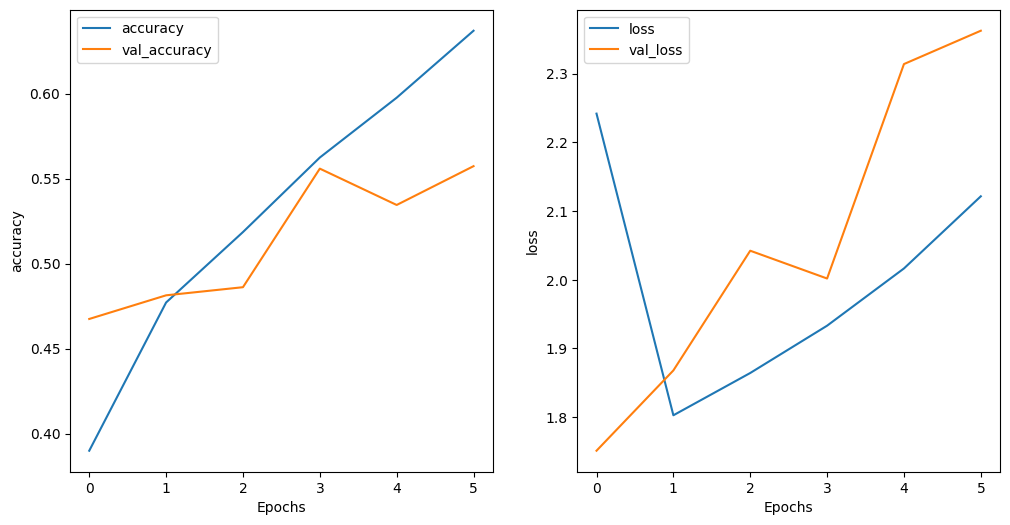

In [73]:
plot_graphs(history=history, strings=['accuracy', 'loss'], filename='/content/graphs/training_history') # , filename='graphs/training_history'

#### Evaluate the model

In [74]:
test_dir_path = '/content/garbage_classification_TrainValidTest/test'

# Create an ImageDataGenerator for test data (no augmentation, just rescaling)
test_datagen = ImageDataGenerator(rescale=(1./255.))

# Load and preprocess test data using the generator
test_generator = test_datagen.flow_from_directory(directory=test_dir_path,
                                                  batch_size=64,
                                                  class_mode='categorical',
                                                  target_size=(300, 300),
                                                  shuffle=False)  # Set shuffle to False to maintain order

# Get the true labels for the test data
true_labels = test_generator.classes

# Get the class labels for the test data
class_labels = list(test_generator.class_indices.keys())

Found 256 images belonging to 6 classes.


In [75]:
class_labels

['cardboard', 'glass', 'metal', 'paper', 'plastic', 'trash']

In [76]:
predictions = model.predict(test_generator)
predicted_labels = np.argmax(predictions, axis=1)
# Generate classification report
print(classification_report(true_labels, predicted_labels, target_names=class_labels))

4/4 [==============================] - 2s 336ms/step
              precision    recall  f1-score   support

   cardboard       0.78      0.78      0.78        41
       glass       0.40      0.39      0.40        51
       metal       0.47      0.20      0.28        41
       paper       0.57      0.47      0.51        60
     plastic       0.46      0.47      0.46        49
       trash       0.16      0.57      0.25        14

    accuracy                           0.46       256
   macro avg       0.47      0.48      0.45       256
weighted avg       0.51      0.46      0.47       256



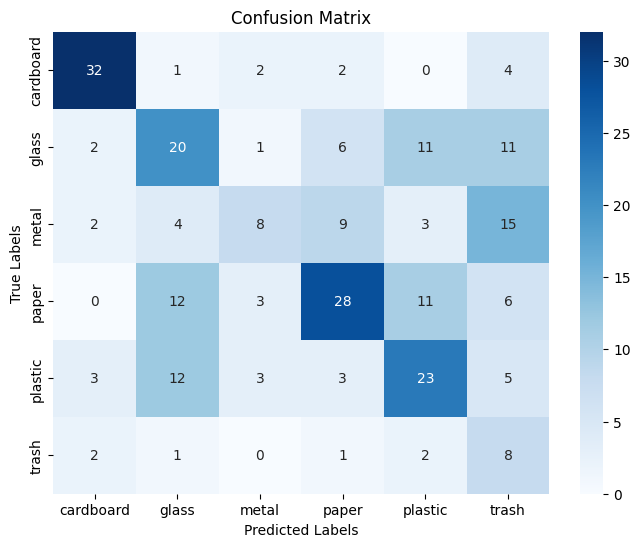

In [77]:
conf_matrix = confusion_matrix(true_labels, predicted_labels)

# Plot the heatmap
plt.figure(figsize=(8, 6))
# sns.set(font_scale=1.2)  # Adjust font size for better visualization
sns.heatmap(conf_matrix, annot=True, fmt='g', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.savefig('/content/graphs/confusion_matrix.png')
plt.show()

#### Save the model

In [ ]:
model.save('/content/models/6_augmentation_garbage_classification_6_classes_model.h5')

In [ ]:
with open('/content/models/histories/5_resnet152_garbage_classification_6_classes_model_history.pkl', 'wb') as f:
    pickle.dump(history.history, f)

### Train the CNN model using Transfer Learning (ResNet50)

#### Example from Kaggle

In [ ]:
from tensorflow.keras.applications import ResNet152
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.applications.resnet50 import preprocess_input

In [ ]:
train_path = '/content/garbage classification/Garbage classification'
valid_path = '/content/garbage classification/Garbage classification'


# extract images to training set by applying data preprocessing and data augmentation
train_batches = ImageDataGenerator(
    preprocessing_function=tf.keras.applications.resnet50.preprocess_input,
    shear_range=0.2,
    zoom_range=0.2,
    width_shift_range=0.2,
    height_shift_range=0.2,
    validation_split=0.1).flow_from_directory(
    directory=train_path, target_size=(224,224), classes=['cardboard', 'glass', 'metal',
                                                         'paper', 'plastic', 'trash'], batch_size=16, subset='training')


# extract images to validation set
valid_batches = ImageDataGenerator(
    preprocessing_function=tf.keras.applications.resnet50.preprocess_input,
    validation_split=0.1).flow_from_directory(
    directory=valid_path, target_size=(224,224), classes=['cardboard', 'glass', 'metal',
                                                         'paper', 'plastic', 'trash'], batch_size=16, subset='validation')

Found 2276 images belonging to 6 classes.
Found 251 images belonging to 6 classes.


In [ ]:
IMG_SIZE = 224
IMG_SHAPE = (IMG_SIZE, IMG_SIZE, 3)

# Load pre-trained ResNet50 model without the top classification layers
base_model = ResNet152(weights='imagenet', include_top=False, input_shape=(IMG_SHAPE))

# Freeze the convolutional base of VGG16 to prevent the pre-trained weights being updated
# during training inorder to extract features
base_model.trainable=False

model = tf.keras.models.Sequential()
model.add(base_model)

# add global average pooling layer
model.add(GlobalAveragePooling2D())

# add densely-connected NN layer with 512 hidden units
model.add(Dense(units=512, activation='relu'))  # use ReLU activation function
model.add(tf.keras.layers.BatchNormalization())                 # normalize and scale inputs or activations
model.add(tf.keras.layers.Dropout(0.2))                         # applies dopout to the input which will randomly disable 20% of hidden units

# add densely-connected NN layer with 128 hidden units
model.add(Dense(units=128, activation='relu')) # use ReLU activation function
model.add(tf.keras.layers.BatchNormalization())                # normalize and scale inputs or activations
model.add(tf.keras.layers.Dropout(0.2))                        # applies dopout to the input which will randomly disable 20% of hidden units

# add densely-connected NN layer with 6 hidden units
model.add(Dense(units=6, activation='softmax')) # use Softmax activation function to do final predictions
model.summary()
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])

In [ ]:
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=10)
mc = ModelCheckpoint('VGG152 Garbage Classifier.h5', monitor='val_acc', mode='max', verbose=1, save_best_only=True)

In [ ]:
history = model.fit_generator(
   train_batches,
    steps_per_epoch=train_batches.samples/train_batches.batch_size ,
    epochs=20,
    validation_data=valid_batches,
    validation_steps=valid_batches.samples/valid_batches.batch_size,
    verbose=1,
    callbacks = [es, mc],)

In [ ]:
plot_graphs(history=history, strings=['accuracy', 'loss'], filename='/content/graphs/training_history')

In [ ]:
model.save('/content/models/4_resnet152_garbage_classification_6_classes_model.h5')

In [ ]:
with open('/content/models/histories/4_resnet152_garbage_classification_6_classes_model_history.pkl', 'wb') as f:
    pickle.dump(history.history, f)

In [ ]:
mc = ModelCheckpoint('VGG152 Garbage Classifier.h5', monitor='val_accuracy', mode='max', verbose=1, save_best_only=True)
loss = history.history['loss']
validation_loss = history.history['val_loss']
accuracy = history.history['accuracy']
validation_accuracy = history.history['val_accuracy']


base_model.trainable=True
history = model.fit_generator(
   train_batches,
    steps_per_epoch=train_batches.samples/train_batches.batch_size ,
    epochs=10,
    validation_data=valid_batches,
    validation_steps=valid_batches.samples/valid_batches.batch_size,
    verbose=1,
    callbacks = [es, mc],)

loss.extend(history.history['loss'])
validation_loss.extend(history.history['val_loss'])
accuracy.extend(history.history['accuracy'])
validation_accuracy.extend(history.history['val_accuracy'])

#### Training by myself

In [78]:
from tensorflow.keras.applications import ResNet152
from tensorflow.keras.applications.resnet50 import preprocess_input

In [79]:
target_size=(224, 224)

datagen = ImageDataGenerator(preprocessing_function=preprocess_input)
train_generator = datagen.flow_from_directory(directory=train_dir_path,
                                              batch_size=32,
                                              class_mode='categorical',
                                              target_size=target_size)

valid_generator = datagen.flow_from_directory(directory=valid_dir_path,
                                              batch_size=32,
                                              class_mode='categorical',
                                              target_size=target_size)

Found 26978 images belonging to 6 classes.
Found 4816 images belonging to 6 classes.


In [80]:
print(f"train_generator.samples/train_generator.batch_size = {train_generator.samples/train_generator.batch_size}")
print(f"valid_generator.samples/valid_generator.batch_size = {valid_generator.samples/valid_generator.batch_size}")

train_generator.samples/train_generator.batch_size = 843.0625
valid_generator.samples/valid_generator.batch_size = 150.5


In [81]:
# Get the true labels for the test data
true_labels = train_generator.classes

class_weights = compute_class_weight('balanced',
                                     classes = np.unique(true_labels),
                                     y = true_labels)


# Create a dictionary to store the class weights
# class_weight_dict = dict(zip(class_labels, class_weights)) - for better understanding
class_weight_dict = dict(zip(np.unique(true_labels), class_weights))

# Print the class weights
print("Class Weights:", class_weight_dict)

Class Weights: {0: 1.0461454940282302, 1: 0.8407504363001745, 2: 1.0260915867944622, 3: 0.7089771891096395, 4: 0.8727355072463768, 5: 3.0881410256410255}


In [82]:
IMG_SIZE = 224
IMG_SHAPE = (IMG_SIZE, IMG_SIZE, 3)

# import the convolution base of the VGG16 model with pre-trained weights
base_model = tf.keras.applications.resnet.ResNet152(input_shape=IMG_SHAPE,
                                        include_top=False,
                                        weights='imagenet')
model = tf.keras.models.Sequential()

# Freeze the convolutional base of VGG16 to prevent the pre-trained weights being updated
# during training inorder to extract features
base_model.trainable=False

# add VGG16 convolution base to initialize sequential model
model.add(base_model)

# add global average pooling layer
model.add(tf.keras.layers.GlobalAveragePooling2D())

# add densely-connected NN layer with 512 hidden units
model.add(tf.keras.layers.Dense(units=512, activation='relu'))  # use ReLU activation function
model.add(tf.keras.layers.BatchNormalization())                 # normalize and scale inputs or activations
model.add(tf.keras.layers.Dropout(0.2))                         # applies dopout to the input which will randomly disable 20% of hidden units

# add densely-connected NN layer with 128 hidden units
model.add(tf.keras.layers.Dense(units=128, activation='relu')) # use ReLU activation function
model.add(tf.keras.layers.BatchNormalization())                # normalize and scale inputs or activations
model.add(tf.keras.layers.Dropout(0.2))                        # applies dopout to the input which will randomly disable 20% of hidden units

# add densely-connected NN layer with 6 hidden units
model.add(tf.keras.layers.Dense(units=6, activation='softmax')) # use Softmax activation function to do final predictions
model.summary()
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])

234698864/234698864 [==============================] - 12s 0us/step
Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet152 (Functional)      (None, 7, 7, 2048)        58370944  
                                                                 
 global_average_pooling2d (  (None, 2048)              0         
 GlobalAveragePooling2D)                                         
                                                                 
 dense_2 (Dense)             (None, 512)               1049088   
                                                                 
 batch_normalization (Batch  (None, 512)               2048      
 Normalization)                                                  
                                                                 
 dropout_1 (Dropout)         (None, 512)               0         
                                                    

In [83]:
class myCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs={}):
        if(logs.get('accuracy')>0.99):
            print("\nReached 99% accuracy so cancelling training!")
            self.model.stop_training = True

In [84]:
my_callback = myCallback()
early_stopping_callback = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=5, restore_best_weights=True)
# model_checkpoint_callback = ModelCheckpoint('VGG152_Garbage_Classifier.h5', monitor='val_accuracy', mode='max', verbose=1, save_best_only=True)

In [85]:
history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples/train_generator.batch_size ,
    epochs=100,
    validation_data=valid_generator,
    validation_steps=valid_generator.samples/valid_generator.batch_size,
    verbose=1,
    callbacks = [early_stopping_callback, my_callback],
    class_weight=class_weight_dict)

Epoch 1/100
843/843 [==============================] - 289s 327ms/step - loss: 0.5051 - accuracy: 0.8197 - val_loss: 0.3527 - val_accuracy: 0.8833
Epoch 2/100
843/843 [==============================] - 270s 320ms/step - loss: 0.1635 - accuracy: 0.9444 - val_loss: 0.3103 - val_accuracy: 0.8951
Epoch 3/100
843/843 [==============================] - 270s 320ms/step - loss: 0.0902 - accuracy: 0.9713 - val_loss: 0.2824 - val_accuracy: 0.9074
Epoch 4/100
843/843 [==============================] - 267s 317ms/step - loss: 0.0615 - accuracy: 0.9816 - val_loss: 0.2991 - val_accuracy: 0.9111
Epoch 5/100
843/843 [==============================] - 264s 313ms/step - loss: 0.0435 - accuracy: 0.9869 - val_loss: 0.2976 - val_accuracy: 0.9097
Epoch 6/100
844/843 [==============================] - ETA: 0s - loss: 0.0337 - accuracy: 0.9906
Reached 99% accuracy so cancelling training!
843/843 [==============================] - 265s 315ms/step - loss: 0.0337 - accuracy: 0.9906 - val_loss: 0.3286 - val_accur

##### Display the training history

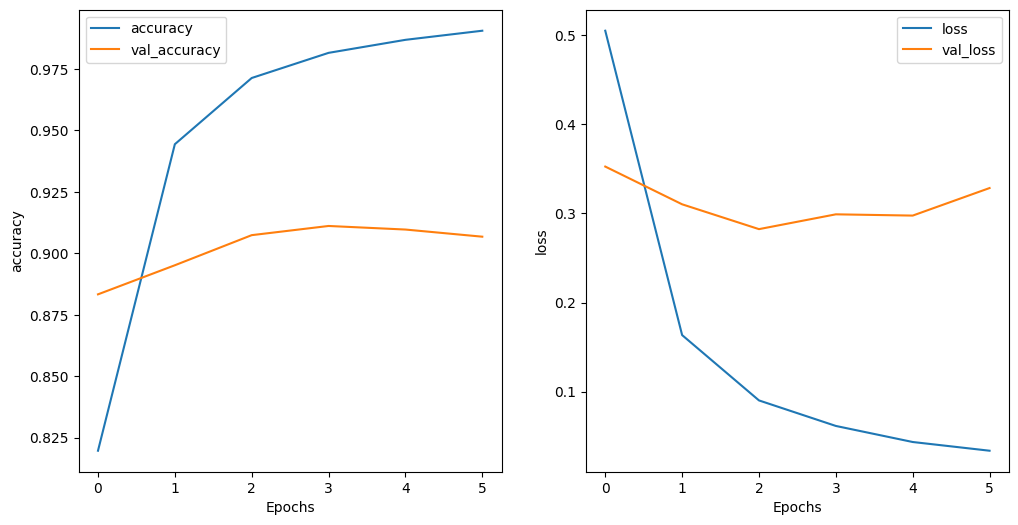

In [86]:
plot_graphs(history=history, strings=['accuracy', 'loss'], filename='/content/graphs/training_history') # , filename='graphs/training_history'

##### Evaluate the model

In [87]:
test_dir_path = '/content/garbage_classification_TrainValidTest/test'
# Create an ImageDataGenerator for test data (no augmentation, just rescaling)
test_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)

# Load and preprocess test data using the generator
test_generator = test_datagen.flow_from_directory(directory=test_dir_path,
                                                  batch_size=64,
                                                  class_mode='categorical',
                                                  target_size=(224, 224),
                                                  shuffle=False)  # Set shuffle to False to maintain order

# Get the true labels for the test data
true_labels = test_generator.classes

# Get the class labels for the test data
class_labels = list(test_generator.class_indices.keys())

Found 256 images belonging to 6 classes.


In [88]:
predictions = model.predict(test_generator)
predicted_labels = np.argmax(predictions, axis=1)

# Generate classification report
print(classification_report(true_labels, predicted_labels, target_names=class_labels))

4/4 [==============================] - 7s 318ms/step
              precision    recall  f1-score   support

   cardboard       1.00      0.90      0.95        41
       glass       0.92      0.94      0.93        51
       metal       0.88      0.88      0.88        41
       paper       0.94      0.97      0.95        60
     plastic       0.98      0.92      0.95        49
       trash       0.78      1.00      0.88        14

    accuracy                           0.93       256
   macro avg       0.92      0.93      0.92       256
weighted avg       0.93      0.93      0.93       256



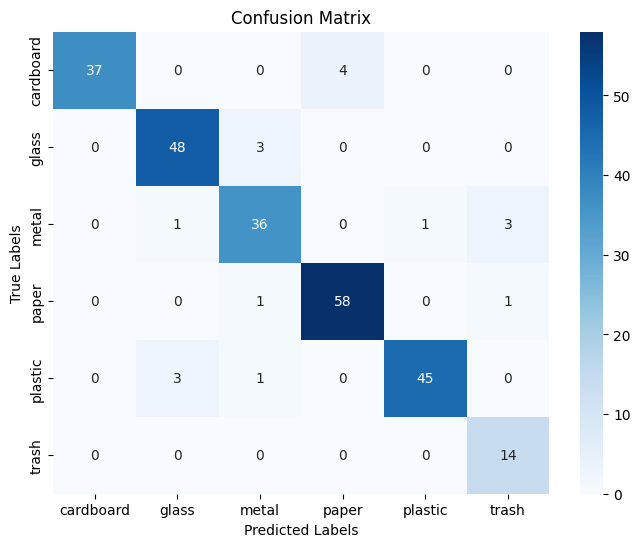

In [92]:
conf_matrix = confusion_matrix(true_labels, predicted_labels)

# Plot the heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.savefig('/content/graphs/resnet152_confusion_matrix.png')
plt.show()

##### Save the model

In [90]:
model.save('/content/models/6_resnet152_garbage_classification_6_classes_model.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [91]:
with open('/content/models/histories/6_resnet152_garbage_classification_6_classes_model_history.pkl', 'wb') as f:
    pickle.dump(history.history, f)